In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparation Work

## Load Python Settings and Packages

In [2]:
# suppress warnings
import warnings;
warnings.filterwarnings("ignore");

# common imports
import pandas as pd
import numpy as np
import re
import glob
import os
import random
import pprint as pp
import html
import nltk
import json

from tqdm.auto import tqdm
# register pandas
tqdm.pandas()

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

## Change the working directory and load train dataset

In [4]:
# change to current directory
BASE_DIR = "/content/drive/MyDrive/Yifei_Master_Paper"
os.chdir(BASE_DIR)

In [5]:
path = "./yelp_academic_dataset_review.json"

data=[]
with open(path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 100000:  # only pick 100K data as our dataset
            break
        data.append(json.loads(line))

In [6]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   useful       100000 non-null  int64  
 5   funny        100000 non-null  int64  
 6   cool         100000 non-null  int64  
 7   text         100000 non-null  object 
 8   date         100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB


In [7]:
# drop unnecessary columns
df = df.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stars   100000 non-null  float64
 1   text    100000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


## Language detection

In [8]:
!pip install langid swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=9f9e130bac3722b2e4d79bcd647983388ee1619de379de84439480d4c91c859d
  Stored in directory: /root/.cache/pip/wheels/3c/bc/9d/266e27289b9019680d65d9b608c37bff1eff565b001c977ec5
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=a8a1e4794543dc1672e003f7384563d6bb7bb11441c1174872e4b332ae0b2c5e
  Stored in directory: /root/.cache/pip/wheels/d9/31/ff/ff51141a088571a9f672449e5aad5ea8bb35ca5d95ba135f30
Successfully built langid swifter


In [9]:
import langid
import swifter

# detect languages
def lang_detect(text):
    if not isinstance(text, str) or len(text.strip()) < 2:
        return "unknown"
    try:
        return langid.classify(text)[0]
    except:
        return "error"

df['lang'] = df['text'].swifter.progress_bar(True).apply(lang_detect)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
# show different languages

df['lang'].value_counts(ascending=False)

lang
en    99886
es       36
fr       17
de       16
it        9
pt        6
id        4
zh        4
nl        4
sv        3
mt        2
ja        2
la        2
da        1
an        1
ro        1
fi        1
is        1
nn        1
oc        1
eu        1
sw        1
Name: count, dtype: int64

In [11]:
df['lang'].nunique()

22

In [12]:
# only keep data in english

df = df[df['lang'] == 'en'].reset_index(drop=True)
df.to_csv("yelp_english.csv", index=False)

In [13]:
df.head(5)

stars                                               text lang
0    3.0  If you decide to eat here, just be aware it is...   en
1    5.0  I've taken a lot of spin classes over the year...   en
2    3.0  Family diner. Had the buffet. Eclectic assortm...   en
3    5.0  Wow!  Yummy, different,  delicious.   Our favo...   en
4    4.0  Cute interior and owner (?) gave us tour of up...   en

In [14]:
df.drop(columns=['lang'],inplace=True)

In [15]:
df.head()

stars                                               text
0    3.0  If you decide to eat here, just be aware it is...
1    5.0  I've taken a lot of spin classes over the year...
2    3.0  Family diner. Had the buffet. Eclectic assortm...
3    5.0  Wow!  Yummy, different,  delicious.   Our favo...
4    4.0  Cute interior and owner (?) gave us tour of up...

# Exploratory Data Analysis


In [16]:
df.shape

(99886, 2)

In [17]:
# check fisrt 5 rows
display(df.head())

stars                                               text
0    3.0  If you decide to eat here, just be aware it is...
1    5.0  I've taken a lot of spin classes over the year...
2    3.0  Family diner. Had the buffet. Eclectic assortm...
3    5.0  Wow!  Yummy, different,  delicious.   Our favo...
4    4.0  Cute interior and owner (?) gave us tour of up...

In [18]:
display(df.describe().T)

count     mean       std  min  25%  50%  75%  max
stars  99886.0  3.84252  1.354961  1.0  3.0  4.0  5.0  5.0

In [19]:
# check categories of each column
df.nunique()

stars        5
text     99850
dtype: int64

In [20]:
df.duplicated().sum()

np.int64(34)

In [21]:
df = df.drop_duplicates()
print(df.duplicated().sum())
print("shape without duplicates:",df.shape)

0
shape without duplicates: (99852, 2)


In [22]:
df.isnull().sum()

stars    0
text     0
dtype: int64

In [23]:
df.stars.value_counts().sort_index()

stars
1.0    10908
2.0     7984
3.0    11354
4.0    25287
5.0    44319
Name: count, dtype: int64

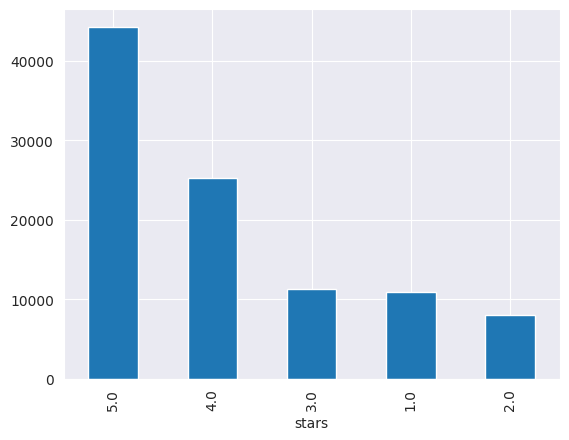

In [24]:
df.stars.value_counts().plot(kind='bar');

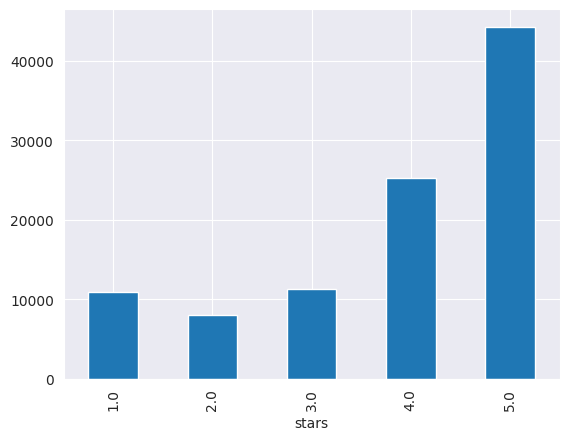

In [25]:
df.stars.value_counts().sort_index().plot(kind='bar');

In [26]:
df.stars.value_counts(normalize=True).sort_index()

stars
1.0    0.109242
2.0    0.079958
3.0    0.113708
4.0    0.253245
5.0    0.443847
Name: proportion, dtype: float64

In [27]:
# calculate the length of each text
df['length'] = df['text'].str.len()
df.describe().T

count        mean         std  min    25%    50%    75%     max
stars   99852.0    3.842497    1.354908  1.0    3.0    4.0    5.0     5.0
length  99852.0  548.730782  501.769711  3.0  226.0  395.0  693.0  5000.0

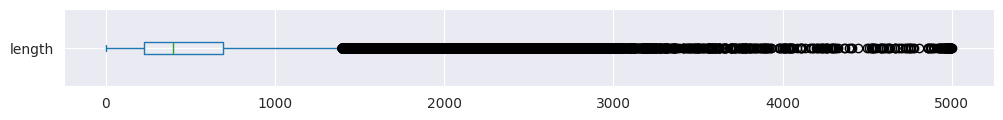

In [28]:
# boxplot of length
df['length'].plot(kind='box',vert=False,figsize=(12,1));

<Axes: ylabel='Frequency'>

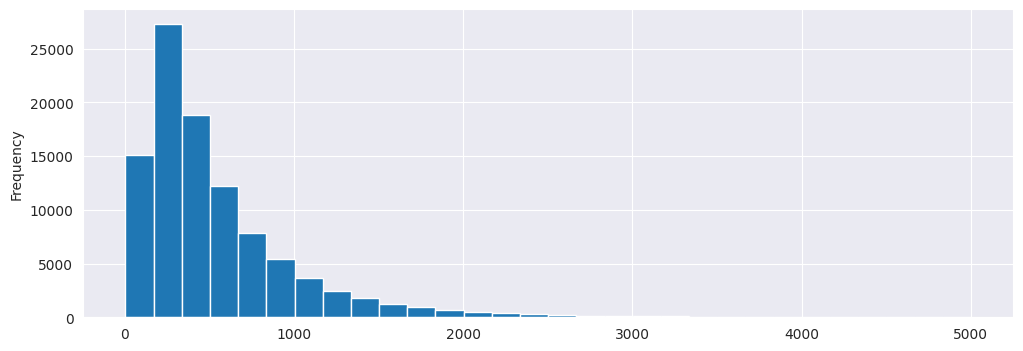

In [29]:
# histplot of length
df['length'].plot(kind='hist',bins=30,figsize=(12,4))

right-skewed distribution: many outliers in the right side/existing of extra long text

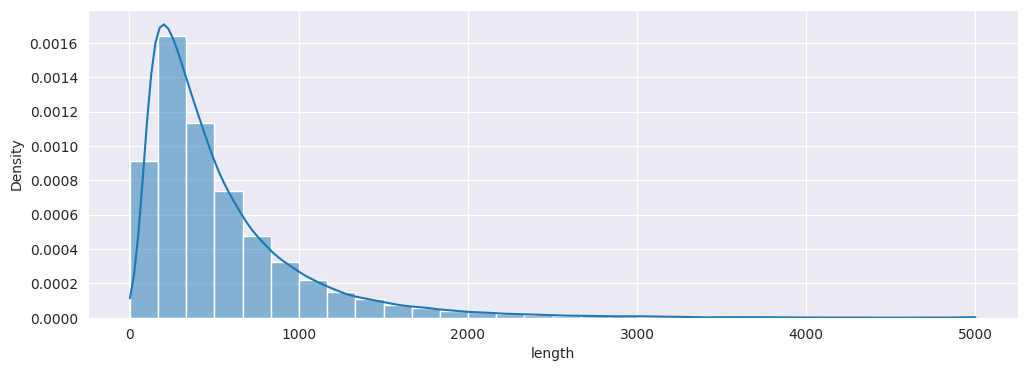

In [30]:
# histplot of length
plt.figure(figsize=(12,4))
sns.histplot(df['length'],bins=30,kde=True,stat='density')
plt.show()

## Cleaning, Tokenization and Removing stop words

In [31]:
# define a cleaning function

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text) #look around the sequence of interest  "^" & "$" stands resp. for beginning and end of a line or string "?:" stands for "look around but don't capture"
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [32]:
df['text'] = df['text'].progress_apply(clean)

Pandas Apply:   0%|          | 0/99852 [00:00<?, ?it/s]

In [33]:
# define a tokenization function by regular expression
import regex as re

def tokenize(text):
    pattern = r"""
        (?:[A-Za-z]\.){2,}          # abbreviations
        | \#\w+               # hashtags
        | \@\w+               # user names
        | [A-Za-z]+(?:['-][A-Za-z]+)*    # words, including hyphenated or apostrophized forms
        | \d+(?:\.\d+)?%?          # numbers or percentages
        | [\p{So}\p{Sk}]           # emoji and special Unicode symbols
    """
    tokens = re.findall(pattern, text, re.VERBOSE)
    return tokens

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [36]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text,pipeline):
  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [37]:
df['tokens'] = df['text'].progress_apply(prepare,pipeline=pipeline)

Pandas Apply:   0%|          | 0/99852 [00:00<?, ?it/s]

In [38]:
df['num_of_tokens'] = df['tokens'].progress_apply(len)
df.head()

Pandas Apply:   0%|          | 0/99852 [00:00<?, ?it/s]

stars                                               text  length  \
0    3.0  If you decide to eat here, just be aware it is...     513   
1    5.0  I've taken a lot of spin classes over the year...     829   
2    3.0  Family diner. Had the buffet. Eclectic assortm...     339   
3    5.0  Wow! Yummy, different, delicious. Our favorite...     243   
4    4.0  Cute interior and owner (?) gave us tour of up...     534   

                                              tokens  num_of_tokens  
0  [decide, eat, aware, going, take, 2, hours, be...             44  
1  [taken, lot, spin, classes, years, nothing, co...             80  
2  [family, diner, buffet, eclectic, assortment, ...             39  
3  [wow, yummy, different, delicious, favorite, l...             23  
4  [cute, interior, owner, gave, us, tour, upcomi...             64

In [39]:
df[df['tokens'].apply(len) == 0]

stars text  length tokens  num_of_tokens
81781    4.0  :-D       3     []              0

In [40]:
df = df[df['tokens'].apply(len) > 0].reset_index(drop=True)

In [41]:
df.head()

stars                                               text  length  \
0    3.0  If you decide to eat here, just be aware it is...     513   
1    5.0  I've taken a lot of spin classes over the year...     829   
2    3.0  Family diner. Had the buffet. Eclectic assortm...     339   
3    5.0  Wow! Yummy, different, delicious. Our favorite...     243   
4    4.0  Cute interior and owner (?) gave us tour of up...     534   

                                              tokens  num_of_tokens  
0  [decide, eat, aware, going, take, 2, hours, be...             44  
1  [taken, lot, spin, classes, years, nothing, co...             80  
2  [family, diner, buffet, eclectic, assortment, ...             39  
3  [wow, yummy, different, delicious, favorite, l...             23  
4  [cute, interior, owner, gave, us, tour, upcomi...             64

## word frequency analysis

In [42]:
# calculate word frequency

from collections import Counter
counter = Counter()
_ = df['tokens'].map(counter.update)

In [43]:
df_most_common = pd.DataFrame(counter.most_common(10),columns=['word','count'])
df_most_common

word  count
0     food  54787
1     good  51281
2    place  49027
3    great  47334
4  service  32482
5     like  31277
6     time  30020
7      one  29318
8      get  29032
9     back  27205

In [44]:
def count_words(df,column='tokens',preprocess=None, min_freq=2):
  def update(doc):
    tokens = doc if preprocess is None else preprocess(doc)
    counter.update(tokens)

  counter = Counter()
  df[column].progress_apply(update)

  freq_df = pd.DataFrame.from_dict(counter, orient='index',columns=['freq'])
  freq_df = freq_df.query('freq>=@min_freq')
  freq_df.index.name = 'token'

  return freq_df.sort_values('freq',ascending=False)

In [45]:
freq_df = count_words(df,column='tokens', preprocess=None, min_freq=2)
freq_df.head(10)

Pandas Apply:   0%|          | 0/99851 [00:00<?, ?it/s]

freq
token         
food     54787
good     51281
place    49027
great    47334
service  32482
like     31277
time     30020
one      29318
get      29032
back     27205

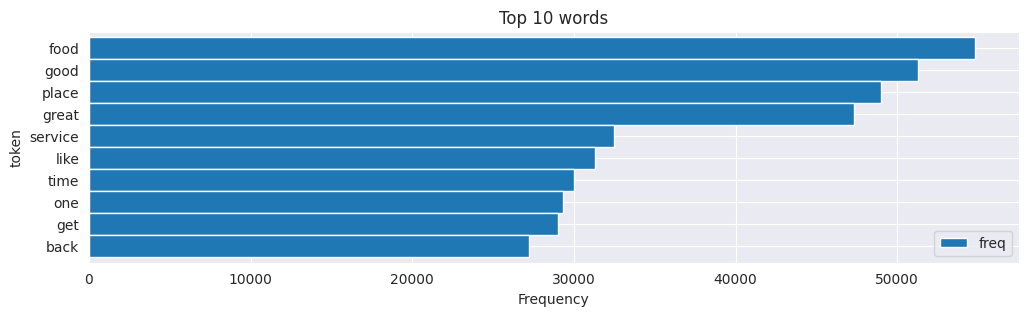

In [46]:
ax = freq_df.head(10).plot.barh(width=1, figsize=(12,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency',ylabel='token',title='Top 10 words');

## Word clouds

In [47]:
from wordcloud import WordCloud

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

  wc = WordCloud(width=1000, height=500,
                  background_color= "black", colormap="Paired",
                  max_font_size=150, max_words=max_words)

  # convert data frame into dict
  if type(word_freq) == pd.Series:
      counter = Counter(word_freq.fillna(0).to_dict())
  else:
      counter = word_freq

  # filter stop words in frequency counter
  if stopwords is not None:
      counter = {token:freq for (token, freq) in counter.items()
                            if token not in stopwords}
  wc.generate_from_frequencies(counter)

  plt.title(title)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()

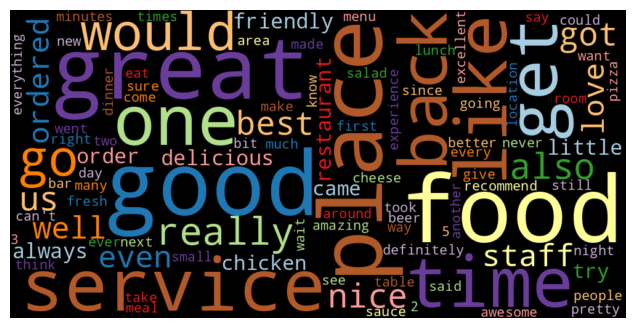

In [48]:
plt.figure(figsize=(10,4))
wordcloud(freq_df['freq'],max_words=100)


## TF-IDF Rank

In [49]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
  def update(doc):
    tokens = doc if preprocess is None else preprocess(doc)
    counter.update(set(tokens))

  # count tokens
  counter = Counter()
  df[column].progress_map(update)

  # create data frame and compute idf
  idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
  idf_df = idf_df.query('df >= @min_df')
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
  idf_df.index.name = 'token'
  return idf_df

idf_df = compute_idf(df, column='tokens', preprocess=None, min_df=2)

Pandas Apply:   0%|          | 0/99851 [00:00<?, ?it/s]

In [50]:
idf_df.sample(5,random_state=42)

df        idf
token                    
hershey      8   9.531993
felix        7   9.665524
hoops        6   9.819675
bobo         3  10.512822
beermaster   2  10.918287

In [51]:
# calculate tfidf

freq_df = freq_df.merge(idf_df, left_index=True, right_index=True, how='left')
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']


In [52]:
freq_df.head(5)

freq       df       idf         tfidf
token                                          
food     54787  37298.0  1.084739  59429.615805
good     51281  34839.0  1.152942  59123.999518
place    49027  35258.0  1.140987  55939.151066
great    47334  34384.0  1.166088  55195.596845
service  32482  27341.0  1.395292  45321.863952

In [53]:
freq_df.sample(5,random_state=10)

freq    df        idf       tfidf
token                                       
colonic       6   4.0  10.225140   61.350840
joys          5   5.0  10.001996   50.009982
bracelets    13  13.0   9.046485  117.604305
handler       4   4.0  10.225140   40.900560
hawk         14  14.0   8.972377  125.613278

In [54]:
freq_df.head(15).sort_values('tfidf',ascending=False)


freq       df       idf         tfidf
token                                          
food     54787  37298.0  1.084739  59429.615805
good     51281  34839.0  1.152942  59123.999518
place    49027  35258.0  1.140987  55939.151066
great    47334  34384.0  1.166088  55195.596845
like     31277  22556.0  1.587678  49657.803833
one      29318  21700.0  1.626367  47681.822261
time     30020  22715.0  1.580654  47451.220340
get      29032  21652.0  1.628581  47280.970731
would    26486  19833.0  1.716332  45458.765586
service  32482  27341.0  1.395292  45321.863952
really   24521  18268.0  1.798528  44101.709490
back     27205  22408.0  1.594261  43371.871508
go       25117  20306.0  1.692763  42517.119881
us       18554  11805.0  2.235156  41471.082648
also     21127  16911.0  1.875715  39628.226095

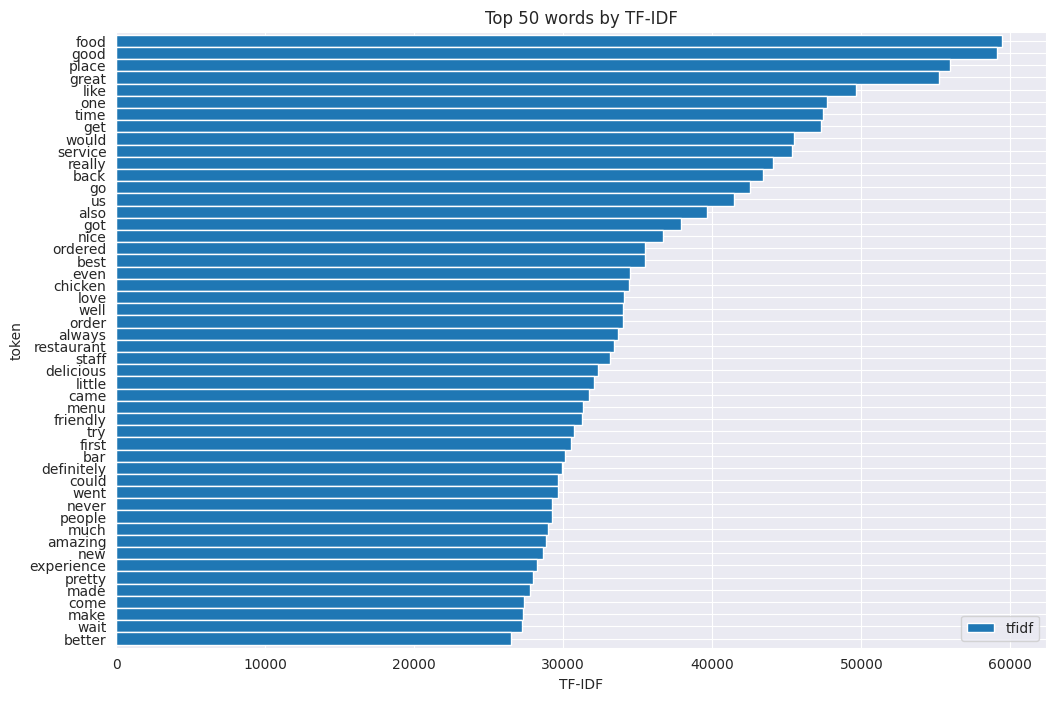

In [55]:
ax = freq_df[['tfidf']].head(50).sort_values('tfidf',ascending=False).plot.barh(width=1,figsize=(12,8))
ax.invert_yaxis()
ax.set(xlabel='TF-IDF',ylabel='token',title='Top 50 words by TF-IDF');

# Traditional machine learning models

## Train Test Split

In [56]:
df.sample(3)

stars                                               text  length  \
37252    4.0  First time at a keke's and I will definitely b...     773   
71037    5.0  The minute that you set foot in The Hideaway, ...     688   
93789    5.0  Fantastic! Great stay at the union station, we...     431   

                                                  tokens  num_of_tokens  
37252  [first, time, keke's, definitely, back, soon, ...             74  
71037  [minute, set, foot, hideaway, swear, stepped, ...             66  
93789  [fantastic, great, stay, union, station, visit...             43

In [57]:
# split dataset

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['stars'],random_state=42)

X_train,y_train = train_df['tokens'],train_df['stars']
X_test,y_test = test_df['tokens'],test_df['stars']

## Vectorization - TfidfVectorizer

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# design the vectorizer
TfidfVectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,       # inputs are tokens
    preprocessor=lambda x: x,    # no preprocessing
    token_pattern=None,
    analyzer='word',
    max_features=20000,
    ngram_range=(1, 2)
)

In [59]:
X_train_tfidf = TfidfVectorizer.fit_transform(X_train)
X_test_tfidf = TfidfVectorizer.transform(X_test)

In [60]:
type(X_train_tfidf)

scipy.sparse._csr.csr_matrix

## Logistic Regression

In [61]:
%%time
logistic_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
logistic_reg.fit(X_train_tfidf, y_train)

CPU times: user 99.5 ms, sys: 48.5 ms, total: 148 ms
Wall time: 35.7 s


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [62]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score

y_pred = logistic_reg.predict(X_test_tfidf)
y_pred_proba = logistic_reg.predict_proba(X_test_tfidf)

print("Accuracy Score：", accuracy_score(y_test,y_pred))
print("ROC-AUC Score：", roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))
print('\n',classification_report(y_test,y_pred))

Accuracy Score： 0.6535476440839217
ROC-AUC Score： 0.8881185341917641

               precision    recall  f1-score   support

         1.0       0.71      0.77      0.74      2182
         2.0       0.51      0.32      0.39      1597
         3.0       0.51      0.36      0.42      2271
         4.0       0.53      0.49      0.51      5057
         5.0       0.73      0.85      0.79      8864

    accuracy                           0.65     19971
   macro avg       0.60      0.56      0.57     19971
weighted avg       0.64      0.65      0.64     19971



In [63]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,y_pred))

[[1680  224   83   60  135]
 [ 440  513  348  174  122]
 [ 141  222  815  768  325]
 [  45   39  302 2486 2185]
 [  46   14   56 1190 7558]]


In [64]:
from sklearn.preprocessing import label_binarize

# get classes
classes = np.unique(y_test)

# binarize to one-vs-rest
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

In [65]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_auc(y_test_bin, y_pred_proba,classes):

  for i in range(n_classes):
      class_label = classes[i]

      # ROC-AUC curve
      fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
      roc_auc = auc(fpr, tpr)

      plt.figure(figsize=(5,5))
      plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.title(f"ROC-AUC Curve - Class {class_label}")
      plt.legend()
      plt.show()


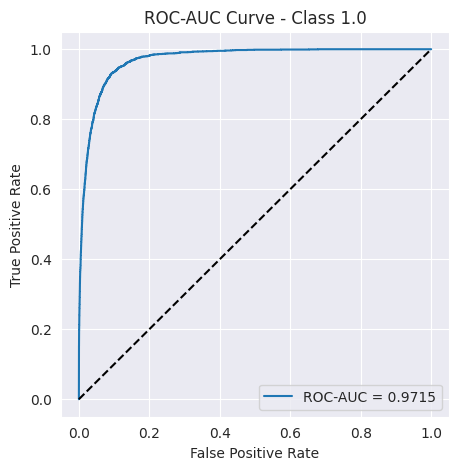

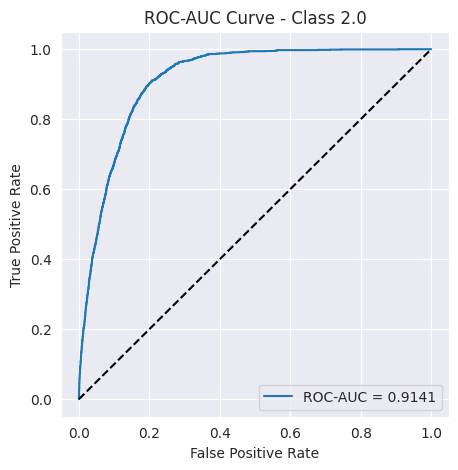

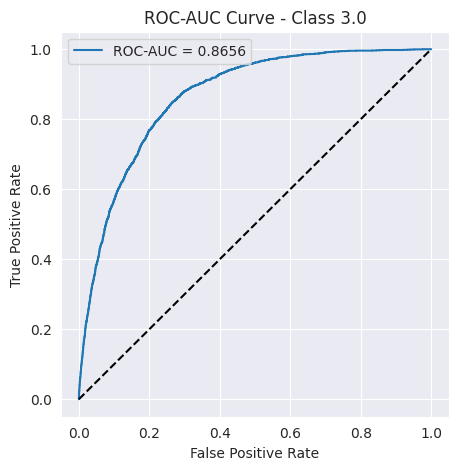

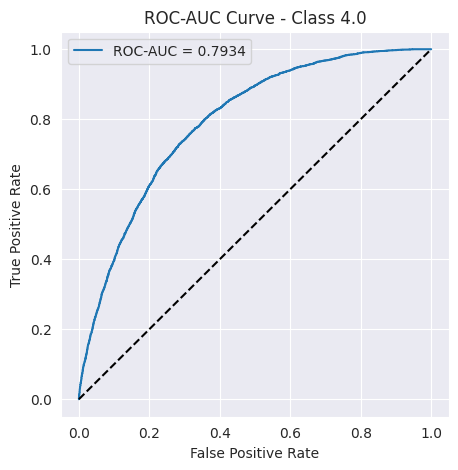

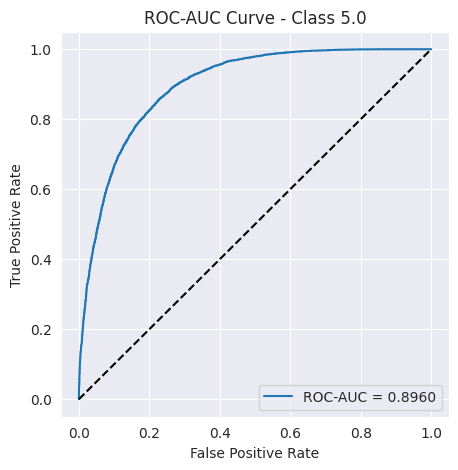

In [66]:
plot_roc_auc(y_test_bin, y_pred_proba, classes)

In [67]:
# show PR-AUC curve

def plot_pr_auc(y_test_bin, y_pred_proba,classes):

  for i in range(n_classes):
      class_label = classes[i]

      precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
      pr_auc = auc(recall, precision)

      plt.figure(figsize=(5,5))
      plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
      plt.xlabel("Recall")
      plt.ylabel("Precision")
      plt.title(f"PR-AUC Curve - Class {class_label}")
      plt.legend()
      plt.show()

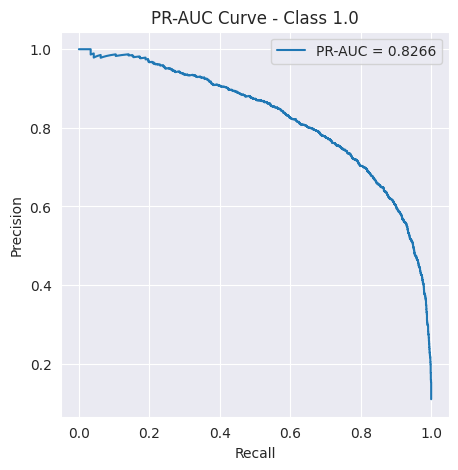

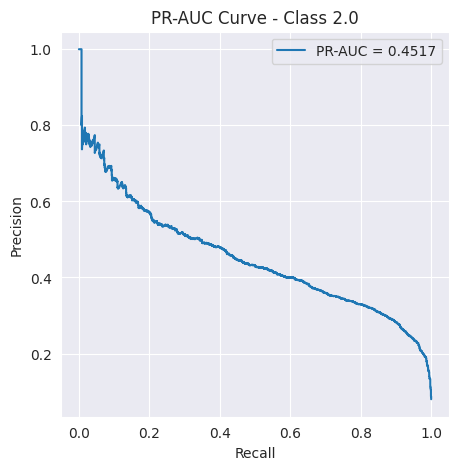

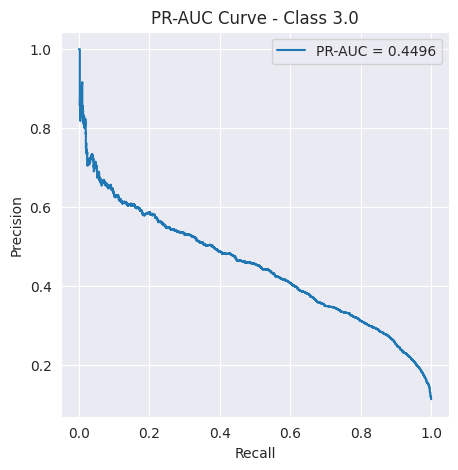

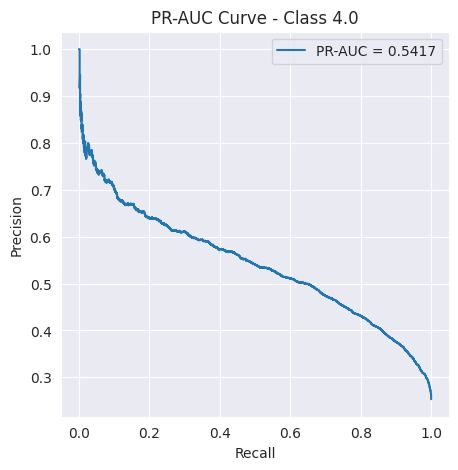

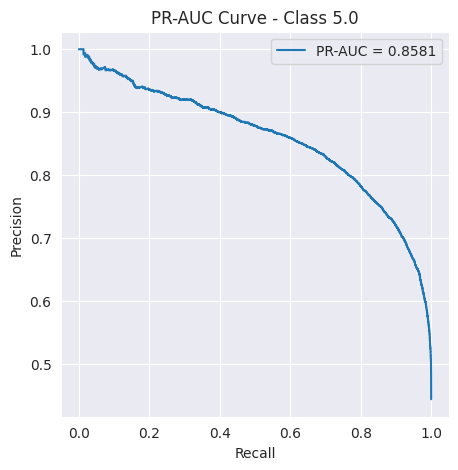

In [68]:
plot_pr_auc(y_test_bin, y_pred_proba, classes)

In [69]:
# calculate overall PR-AUC score

print("PR-AUC Score: ", average_precision_score(y_test_bin,y_pred_proba,average='macro'))

PR-AUC Score:  0.6256647330560262


In [70]:
# find the best threshold for each class

def find_best_thresholds(y_test_bin, y_pred_proba, classes):

    best_thresholds = {}

    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])

        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        best_idx = np.argmax(f1)

        best_threshold = thresholds[best_idx]
        best_thresholds[classes[i]] = best_threshold

        print(f"Class {classes[i]} | best threshold = {best_threshold:.4f} | F1={f1[best_idx]:.4f}")

    return best_thresholds


In [71]:
best_thresholds = find_best_thresholds(y_test_bin, y_pred_proba, classes)

Class 1.0 | best threshold = 0.3258 | F1=0.7517
Class 2.0 | best threshold = 0.1973 | F1=0.4843
Class 3.0 | best threshold = 0.2269 | F1=0.4869
Class 4.0 | best threshold = 0.2734 | F1=0.5674
Class 5.0 | best threshold = 0.3745 | F1=0.8013


In [72]:
# set new logic for prediction

def predict(y_pred_proba, thresholds, classes):
    preds = []
    for row in y_pred_proba:
        result = []

        # find classes >= threshold
        for i, cls in enumerate(classes):
            if row[i] >= thresholds[cls]:
                result.append((cls, row[i]))

        # otherwise, use argmax
        if len(result) == 0:
            preds.append(classes[np.argmax(row)])

        # if more classes, choose the max one
        else:
            preds.append(max(result, key=lambda x: x[1])[0])

    return np.array(preds)

In [73]:
y_pred_new = predict(y_pred_proba, best_thresholds, classes)

print("Accuracy Score：", accuracy_score(y_test,y_pred_new))
print('\n',classification_report(y_test,y_pred_new))

Accuracy Score： 0.6545991687947524

               precision    recall  f1-score   support

         1.0       0.72      0.76      0.74      2182
         2.0       0.49      0.34      0.40      1597
         3.0       0.50      0.37      0.43      2271
         4.0       0.53      0.50      0.51      5057
         5.0       0.74      0.85      0.79      8864

    accuracy                           0.65     19971
   macro avg       0.60      0.56      0.57     19971
weighted avg       0.64      0.65      0.64     19971



We can see that despite we have selected the best classification threshold for each category; the new predictions show quite little improvement in performance. We infer that the predicted results do not change more, because many probabilities do not exceed their threshold.

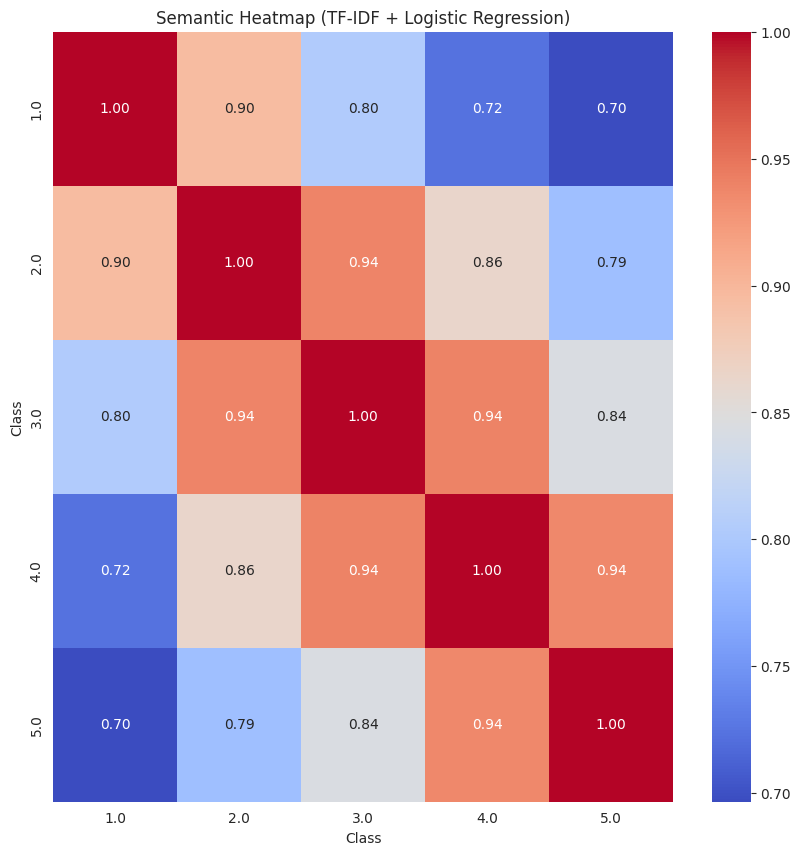

In [74]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# turn to dense matrix
X_dense = X_test_tfidf.toarray()
labels = np.array(y_test)

# calculate centorids
classes = np.unique(labels)
centroids = np.array([X_dense[labels == c].mean(axis=0) for c in classes])

# calculate cosine similarity
class_sim = cosine_similarity(centroids)
df_sim = pd.DataFrame(class_sim, index=classes, columns=classes)

# heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df_sim, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Semantic Heatmap (TF-IDF + Logistic Regression)")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()


---

In [75]:
%%time
balanced_logistic_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, class_weight='balanced')
balanced_logistic_reg.fit(X_train_tfidf, y_train)

CPU times: user 62.1 ms, sys: 31.8 ms, total: 93.9 ms
Wall time: 22.1 s


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [76]:
y_pred = balanced_logistic_reg.predict(X_test_tfidf)
y_pred_proba = balanced_logistic_reg.predict_proba(X_test_tfidf)

print("Accuracy Score：", accuracy_score(y_test,y_pred))
print("ROC-AUC Score：", roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))
print(classification_report(y_test,y_pred))

Accuracy Score： 0.631315407340644
ROC-AUC Score： 0.8788364345902477
              precision    recall  f1-score   support

         1.0       0.68      0.75      0.72      2182
         2.0       0.41      0.46      0.43      1597
         3.0       0.41      0.46      0.43      2271
         4.0       0.52      0.52      0.52      5057
         5.0       0.81      0.74      0.77      8864

    accuracy                           0.63     19971
   macro avg       0.57      0.59      0.57     19971
weighted avg       0.64      0.63      0.64     19971



## LinearSVC

In [77]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

balanced_linear_svc = LinearSVC(random_state=42,class_weight='balanced')
balanced_linear_svc.fit(X_train_tfidf,y_train)

LinearSVC(class_weight='balanced', random_state=42)

In [78]:
y_pred = balanced_linear_svc.predict(X_test_tfidf)
y_score = balanced_linear_svc.decision_function(X_test_tfidf)
y_score_prob = (y_score - y_score.min(axis=1, keepdims=True))
y_pred_prob = y_score_prob / y_score_prob.sum(axis=1, keepdims=True)

print("Accuracy Score：", accuracy_score(y_test,y_pred))
print("ROC-AUC Score：", roc_auc_score(y_test,y_pred_prob,multi_class='ovr'))
print(classification_report(y_test,y_pred))

Accuracy Score： 0.6151419558359621
ROC-AUC Score： 0.8248564100290989
              precision    recall  f1-score   support

         1.0       0.67      0.73      0.70      2182
         2.0       0.37      0.38      0.38      1597
         3.0       0.38      0.41      0.39      2271
         4.0       0.50      0.45      0.47      5057
         5.0       0.76      0.78      0.77      8864

    accuracy                           0.62     19971
   macro avg       0.54      0.55      0.54     19971
weighted avg       0.61      0.62      0.61     19971



In [79]:
print(confusion_matrix(y_test,y_pred))

[[1587  361  132   44   58]
 [ 434  613  394   98   58]
 [ 163  410  922  558  218]
 [  91  175  732 2253 1806]
 [  92   87  262 1513 6910]]


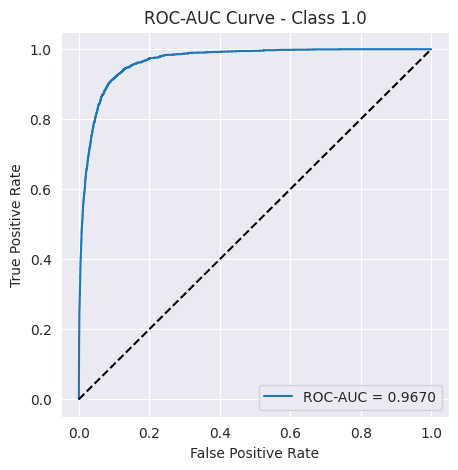

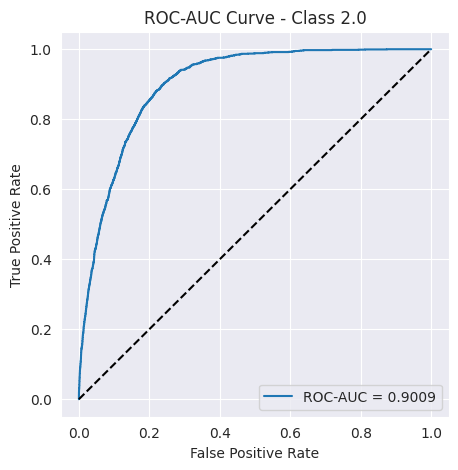

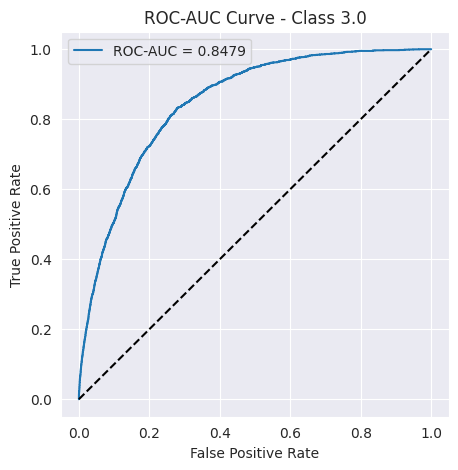

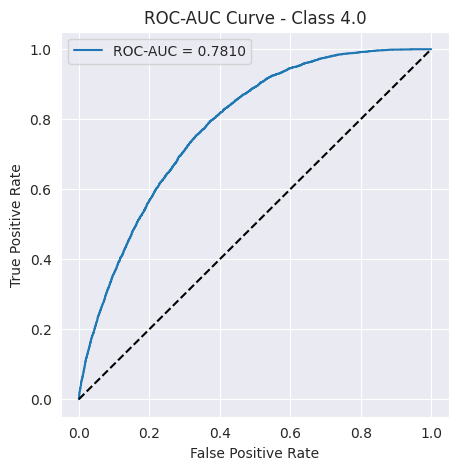

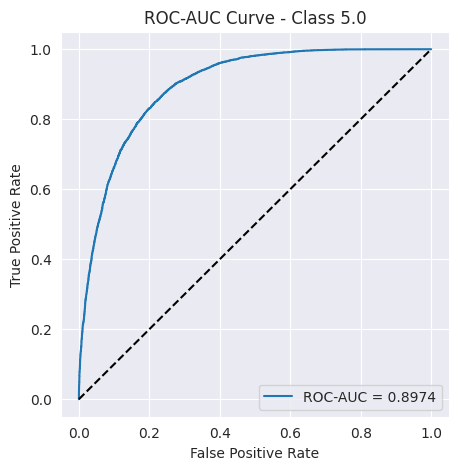

In [80]:
plot_roc_auc(y_test_bin, y_pred_proba, classes)

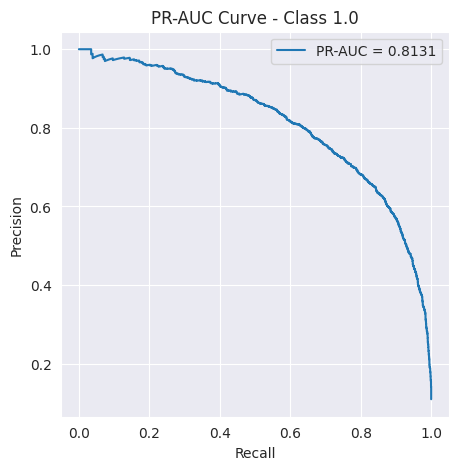

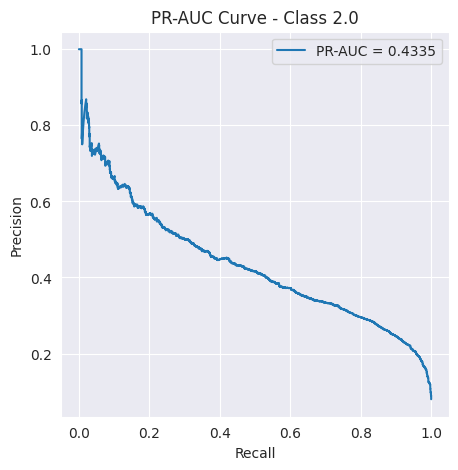

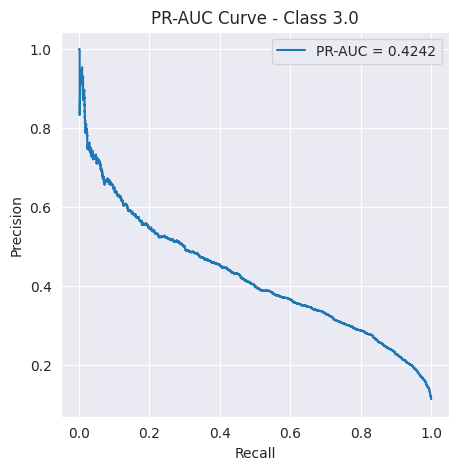

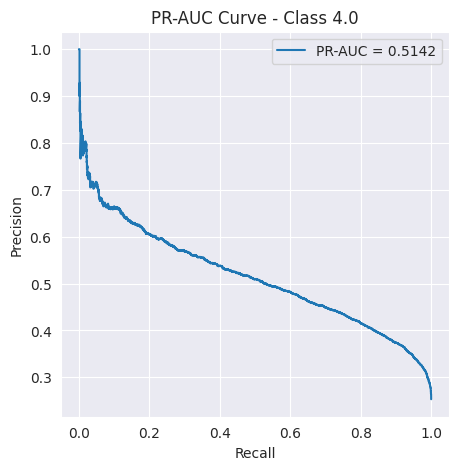

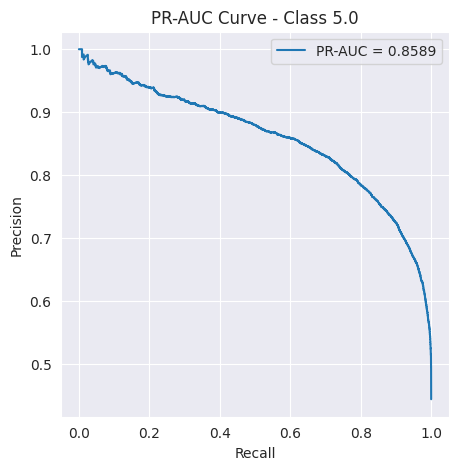

In [81]:
plot_pr_auc(y_test_bin, y_pred_proba, classes)

In [82]:
print("PR-AUC Score: ", average_precision_score(y_test_bin,y_pred_proba,average='macro'))

PR-AUC Score:  0.6089518390068964


In [83]:
best_thresholds = find_best_thresholds(y_test_bin, y_pred_proba, classes)

Class 1.0 | best threshold = 0.3475 | F1=0.7396
Class 2.0 | best threshold = 0.2897 | F1=0.4598
Class 3.0 | best threshold = 0.2840 | F1=0.4556
Class 4.0 | best threshold = 0.2671 | F1=0.5513
Class 5.0 | best threshold = 0.2321 | F1=0.8035


In [84]:
y_pred_new = predict(y_pred_proba, best_thresholds, classes)

print("Accuracy Score：", accuracy_score(y_test,y_pred_new))
print('\n',classification_report(y_test,y_pred_new))

Accuracy Score： 0.6319162786039758

               precision    recall  f1-score   support

         1.0       0.69      0.75      0.72      2182
         2.0       0.41      0.46      0.43      1597
         3.0       0.41      0.46      0.44      2271
         4.0       0.52      0.52      0.52      5057
         5.0       0.80      0.74      0.77      8864

    accuracy                           0.63     19971
   macro avg       0.57      0.59      0.58     19971
weighted avg       0.64      0.63      0.64     19971



## Random Forest

In [85]:
%%time
random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=30,
    random_state=42,
    n_jobs=-1)
random_forest.fit(X_train_tfidf,y_train)

CPU times: user 1min 7s, sys: 175 ms, total: 1min 7s
Wall time: 39.9 s


RandomForestClassifier(max_depth=30, n_jobs=-1, random_state=42)

In [86]:
y_pred = random_forest.predict(X_test_tfidf)
y_pred_proba = random_forest.predict_proba(X_test_tfidf)

print('Accuracy Score：', accuracy_score(y_test,y_pred))
print('ROC-AUC Score：', roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))
print(classification_report(y_test,y_pred))

Accuracy Score： 0.5068849832256772
ROC-AUC Score： 0.8324837524388016
              precision    recall  f1-score   support

         1.0       0.73      0.37      0.49      2182
         2.0       0.57      0.01      0.01      1597
         3.0       0.65      0.03      0.06      2271
         4.0       0.43      0.09      0.15      5057
         5.0       0.50      0.99      0.66      8864

    accuracy                           0.51     19971
   macro avg       0.58      0.30      0.28     19971
weighted avg       0.53      0.51      0.39     19971



In [87]:
print(confusion_matrix(y_test,y_pred))

[[ 817    5   11   27 1322]
 [ 212    8   21  155 1201]
 [  68    1   72  339 1791]
 [  14    0    7  458 4578]
 [  11    0    0   85 8768]]


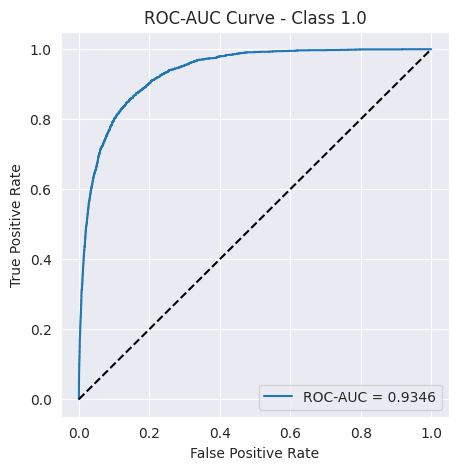

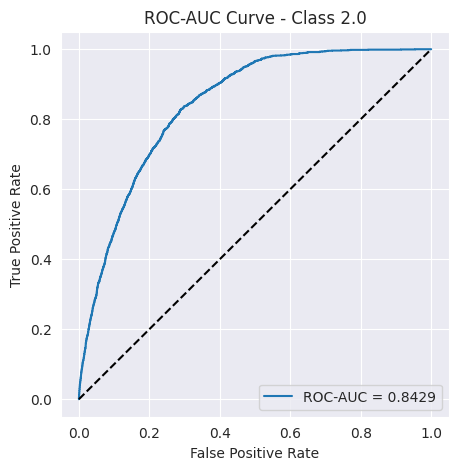

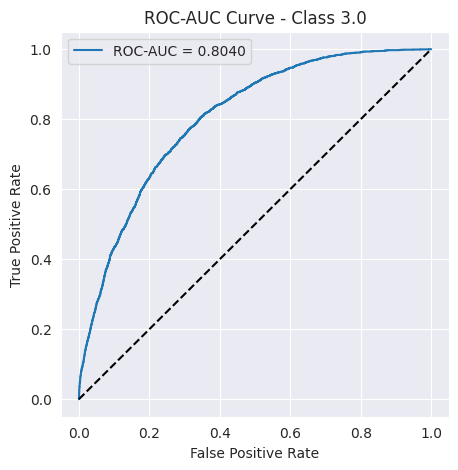

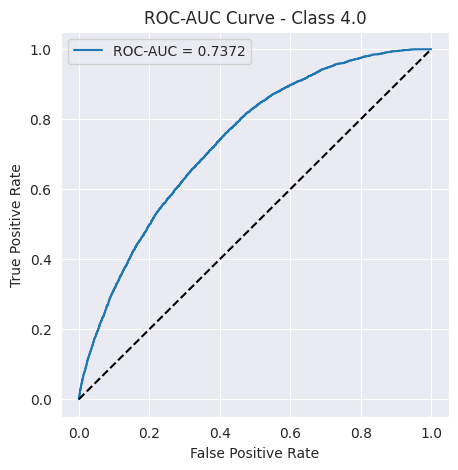

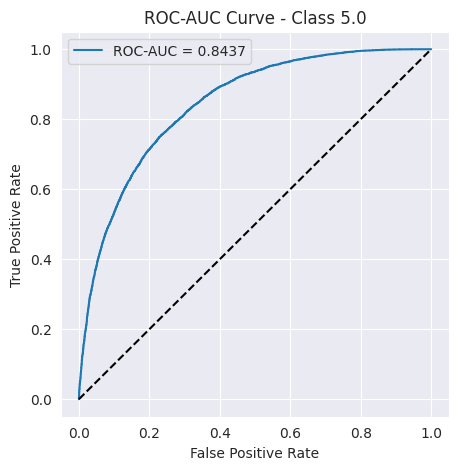

In [88]:
plot_roc_auc(y_test_bin, y_pred_proba, classes)

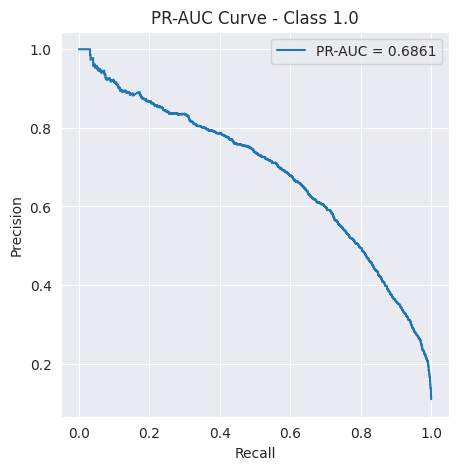

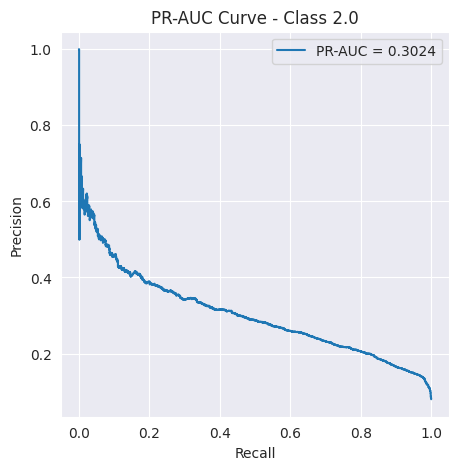

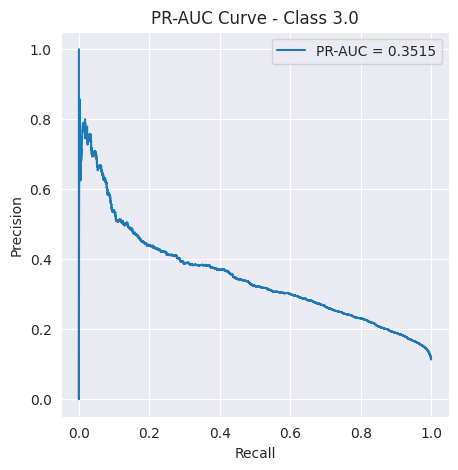

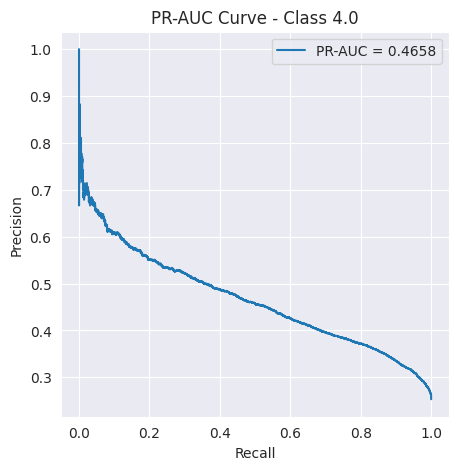

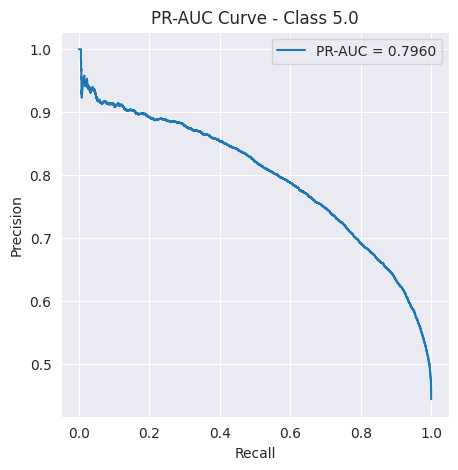

In [89]:
plot_pr_auc(y_test_bin, y_pred_proba, classes)

In [90]:
print('PR-AUC Score: ', average_precision_score(y_test_bin,y_pred_proba,average='macro'))

PR-AUC Score:  0.5206235891404417


In [91]:
best_thresholds = find_best_thresholds(y_test_bin, y_pred_proba, classes)

Class 1.0 | best threshold = 0.1872 | F1=0.6467
Class 2.0 | best threshold = 0.1118 | F1=0.3678
Class 3.0 | best threshold = 0.1359 | F1=0.4016
Class 4.0 | best threshold = 0.2507 | F1=0.5088
Class 5.0 | best threshold = 0.4316 | F1=0.7477


In [92]:
y_pred_new = predict(y_pred_proba, best_thresholds, classes)

print('Accuracy Score：', accuracy_score(y_test,y_pred_new))
print('\n',classification_report(y_test,y_pred_new))

Accuracy Score： 0.5794401882729958

               precision    recall  f1-score   support

         1.0       0.64      0.68      0.66      2182
         2.0       0.45      0.08      0.13      1597
         3.0       0.39      0.14      0.20      2271
         4.0       0.42      0.38      0.40      5057
         5.0       0.64      0.88      0.74      8864

    accuracy                           0.58     19971
   macro avg       0.51      0.43      0.43     19971
weighted avg       0.54      0.58      0.54     19971



## Gradient Boosting

In [93]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier(n_estimators=50,max_depth=3,random_state=42)

gradient_boosting.fit(X_train_tfidf,y_train)

GradientBoostingClassifier(n_estimators=50, random_state=42)

In [94]:
y_pred = gradient_boosting.predict(X_test_tfidf)
y_pred_proba = gradient_boosting.predict_proba(X_test_tfidf)

print('Accuracy Score：', accuracy_score(y_test,y_pred))
print('ROC-AUC Score：', roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))
print(classification_report(y_test,y_pred))

Accuracy Score： 0.5602123078463772
ROC-AUC Score： 0.8135446031719316
              precision    recall  f1-score   support

         1.0       0.71      0.48      0.57      2182
         2.0       0.51      0.11      0.18      1597
         3.0       0.51      0.16      0.24      2271
         4.0       0.46      0.28      0.35      5057
         5.0       0.57      0.92      0.71      8864

    accuracy                           0.56     19971
   macro avg       0.55      0.39      0.41     19971
weighted avg       0.55      0.56      0.51     19971



In [95]:
print(confusion_matrix(y_test,y_pred))

[[1052   87   56  110  877]
 [ 262  178  140  281  736]
 [  97   73  356  684 1061]
 [  33   10  117 1436 3461]
 [  41    2   26  629 8166]]


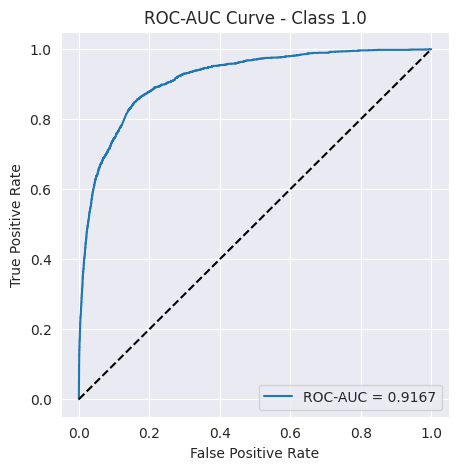

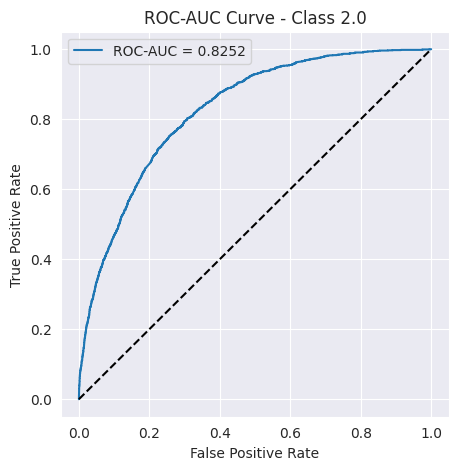

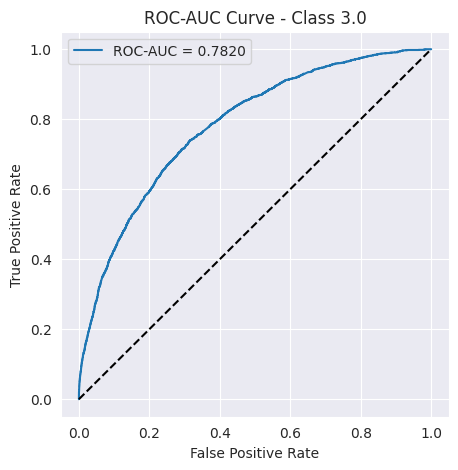

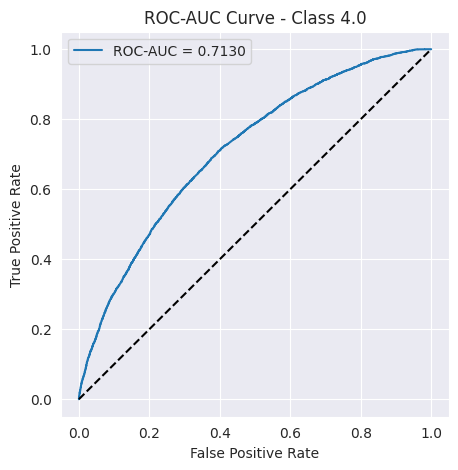

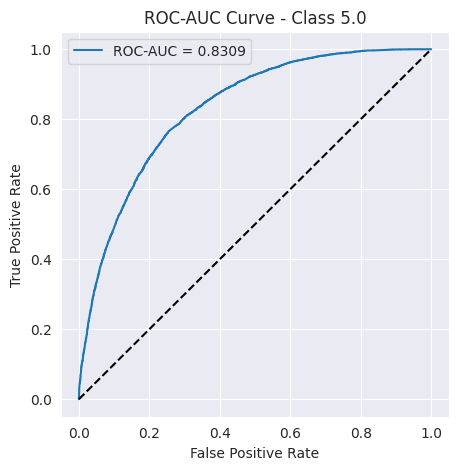

In [96]:
plot_roc_auc(y_test_bin, y_pred_proba, classes)

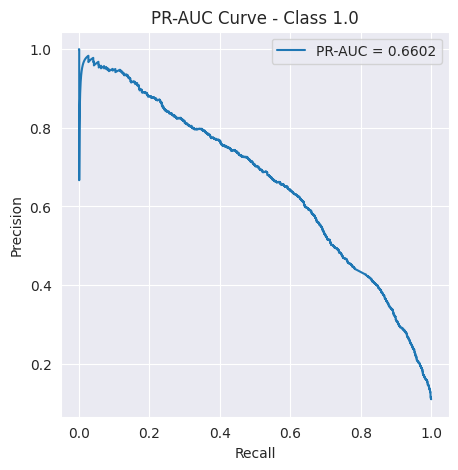

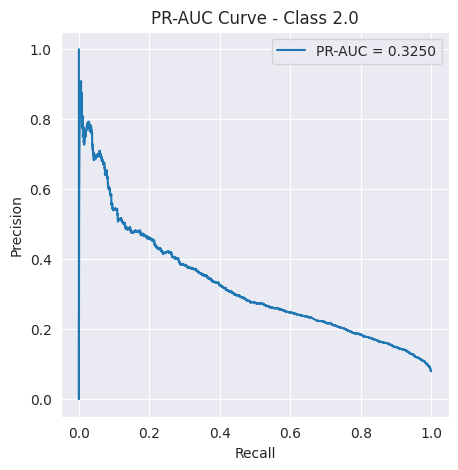

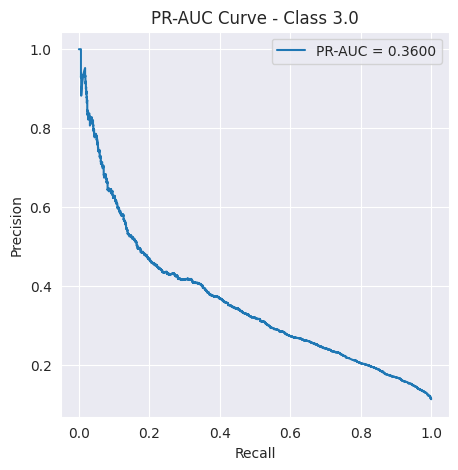

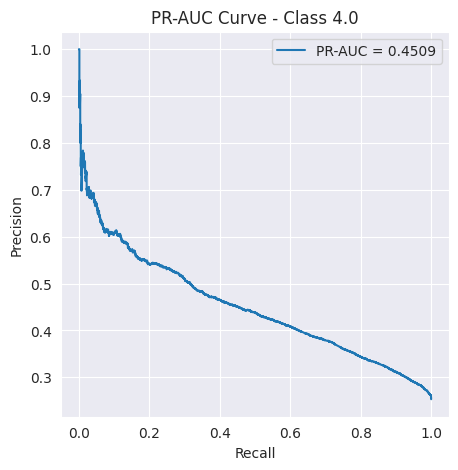

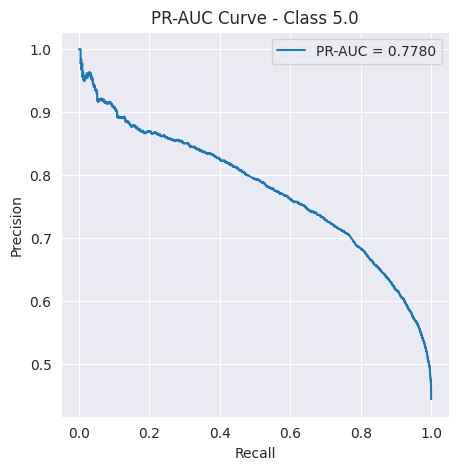

In [97]:
plot_pr_auc(y_test_bin, y_pred_proba, classes)

In [98]:
print('PR-AUC Score: ', average_precision_score(y_test_bin,y_pred_proba,average='macro'))

PR-AUC Score:  0.5149667243906282


In [99]:
best_thresholds = find_best_thresholds(y_test_bin, y_pred_proba, classes)

Class 1.0 | best threshold = 0.2054 | F1=0.6250
Class 2.0 | best threshold = 0.1329 | F1=0.3625
Class 3.0 | best threshold = 0.1484 | F1=0.3919
Class 4.0 | best threshold = 0.2498 | F1=0.4928
Class 5.0 | best threshold = 0.4263 | F1=0.7389


In [100]:
y_pred_new = predict(y_pred_proba, best_thresholds, classes)

print('Accuracy Score：', accuracy_score(y_test,y_pred_new))
print('\n',classification_report(y_test,y_pred_new))

Accuracy Score： 0.5787391717991087

               precision    recall  f1-score   support

         1.0       0.66      0.60      0.63      2182
         2.0       0.45      0.17      0.24      1597
         3.0       0.44      0.21      0.28      2271
         4.0       0.41      0.45      0.43      5057
         5.0       0.67      0.82      0.74      8864

    accuracy                           0.58     19971
   macro avg       0.53      0.45      0.46     19971
weighted avg       0.56      0.58      0.56     19971



## XGBoost

In [101]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [102]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    objective='multi:softprob',
    num_class=5,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_tfidf,y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_class=5, ...)

In [103]:
y_pred_new = xgb.predict(X_test_tfidf)
y_pred = encoder.inverse_transform(y_pred_new)
y_pred_proba = xgb.predict_proba(X_test_tfidf)

print('Accuracy Score：', accuracy_score(y_test,y_pred))
print('ROC-AUC Score：', roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))
print(classification_report(y_test,y_pred))

Accuracy Score： 0.6106354213609734
ROC-AUC Score： 0.8534767318400597
              precision    recall  f1-score   support

         1.0       0.68      0.65      0.67      2182
         2.0       0.50      0.21      0.30      1597
         3.0       0.50      0.25      0.34      2271
         4.0       0.51      0.38      0.43      5057
         5.0       0.65      0.90      0.75      8864

    accuracy                           0.61     19971
   macro avg       0.57      0.48      0.50     19971
weighted avg       0.59      0.61      0.58     19971



In [104]:
print(confusion_matrix(y_test,y_pred))

[[1425  165   66   91  435]
 [ 389  338  242  235  393]
 [ 152  148  573  744  654]
 [  51   21  217 1919 2849]
 [  70    7   38  809 7940]]


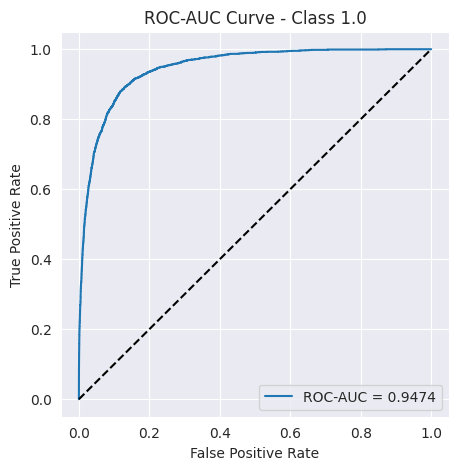

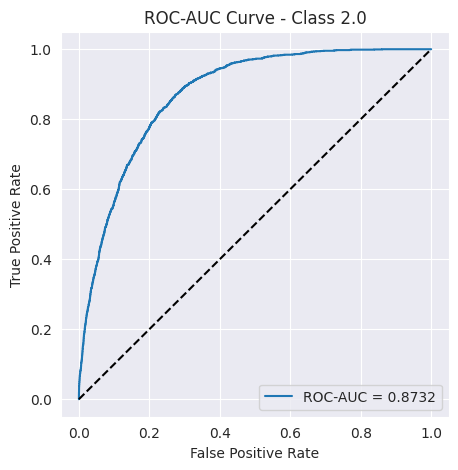

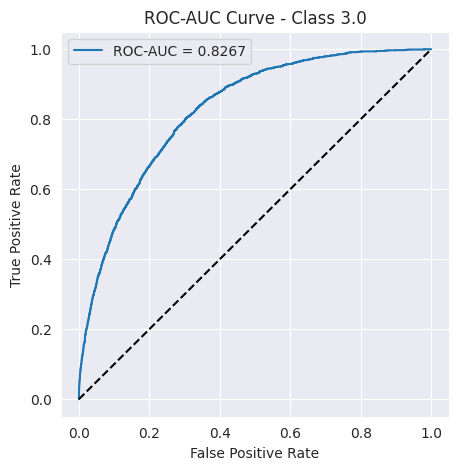

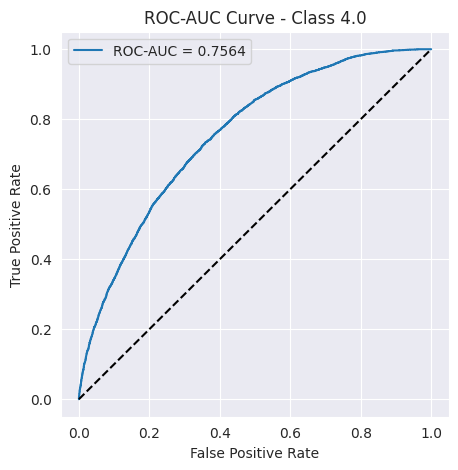

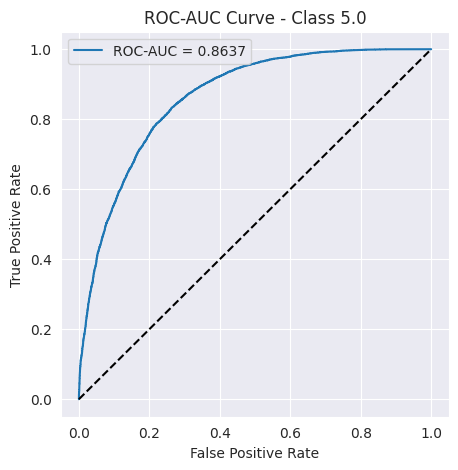

In [105]:
plot_roc_auc(y_test_bin, y_pred_proba, classes)

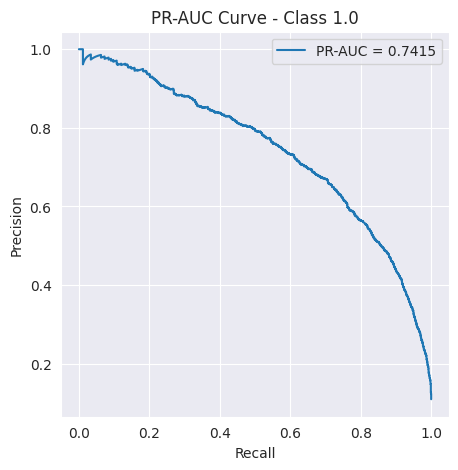

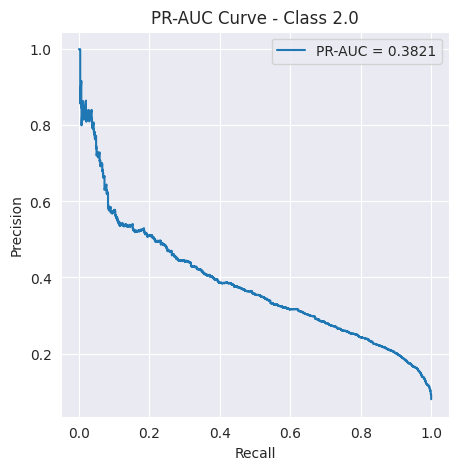

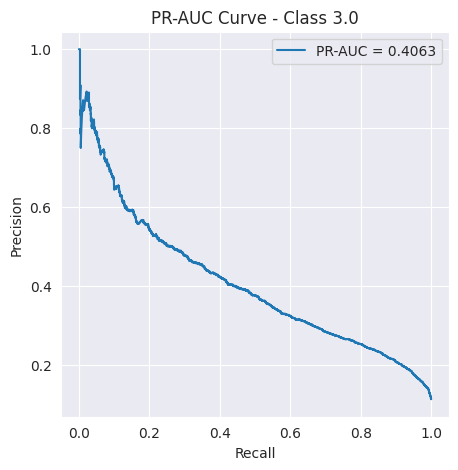

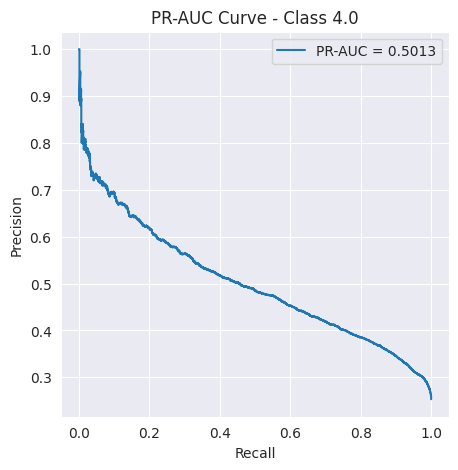

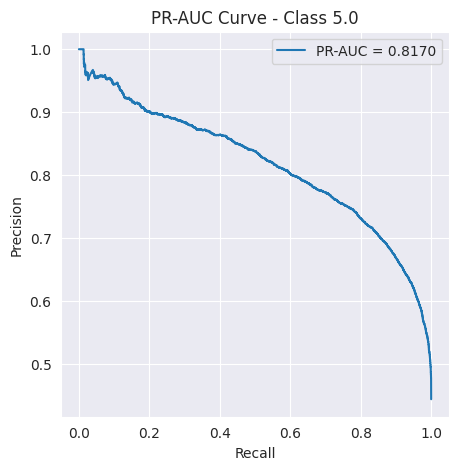

In [106]:
plot_pr_auc(y_test_bin, y_pred_proba, classes)

In [107]:
print('PR-AUC Score: ', average_precision_score(y_test_bin,y_pred_proba,average='macro'))

PR-AUC Score:  0.5697853300070415


In [108]:
best_thresholds = find_best_thresholds(y_test_bin, y_pred_proba, classes)

Class 1.0 | best threshold = 0.2683 | F1=0.6862
Class 2.0 | best threshold = 0.1368 | F1=0.4197
Class 3.0 | best threshold = 0.1893 | F1=0.4308
Class 4.0 | best threshold = 0.2539 | F1=0.5254
Class 5.0 | best threshold = 0.3953 | F1=0.7715


In [109]:
y_pred_new = predict(y_pred_proba, best_thresholds, classes)

print('Accuracy Score：', accuracy_score(y_test, y_pred_new))
print('\n',classification_report(y_test, y_pred_new))

Accuracy Score： 0.6173952230734565

               precision    recall  f1-score   support

         1.0       0.69      0.68      0.68      2182
         2.0       0.44      0.27      0.34      1597
         3.0       0.49      0.27      0.35      2271
         4.0       0.49      0.42      0.45      5057
         5.0       0.69      0.87      0.77      8864

    accuracy                           0.62     19971
   macro avg       0.56      0.50      0.52     19971
weighted avg       0.59      0.62      0.59     19971



## LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=4,
    n_jobs=-1,
    )

lgbm.fit(X_train_tfidf,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.433385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871781
[LightGBM] [Info] Number of data points in the train set: 79880, number of used features: 19965
[LightGBM] [Info] Start training from score -2.214218
[LightGBM] [Info] Start training from score -2.526261
[LightGBM] [Info] Start training from score -2.174121
[LightGBM] [Info] Start training from score -1.373408
[LightGBM] [Info] Start training from score -0.812261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(max_depth=3, n_jobs=-1, random_state=4)

In [ ]:
y_pred = lgbm.predict(X_test_tfidf)
y_pred_proba = lgbm.predict_proba(X_test_tfidf)

print('Accuracy Score：', accuracy_score(y_test,y_pred))
print('ROC-AUC Score：', roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))
print(classification_report(y_test,y_pred))

Accuracy Score： 0.5902057984076912
ROC-AUC Score： 0.8397107406989115
              precision    recall  f1-score   support

         1.0       0.69      0.60      0.64      2182
         2.0       0.53      0.17      0.26      1597
         3.0       0.51      0.20      0.29      2271
         4.0       0.48      0.33      0.39      5057
         5.0       0.61      0.91      0.73      8864

    accuracy                           0.59     19971
   macro avg       0.57      0.44      0.46     19971
weighted avg       0.57      0.59      0.55     19971



In [ ]:
print(confusion_matrix(y_test,y_pred))

[[1300  121   59  108  594]
 [ 334  278  184  259  542]
 [ 129  105  451  744  842]
 [  49   17  158 1676 3157]
 [  65    5   30  682 8082]]


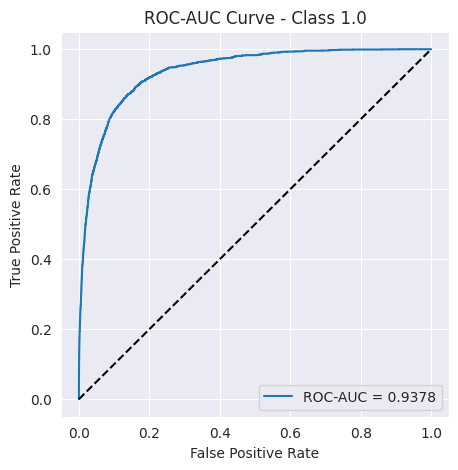

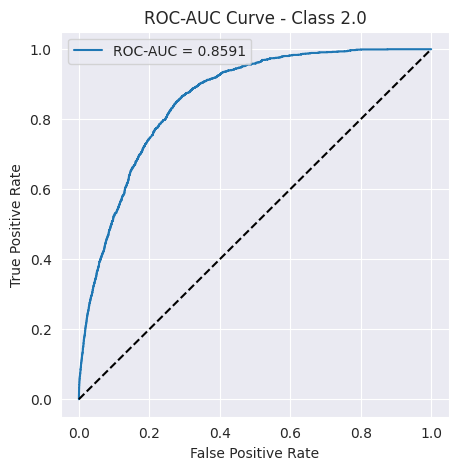

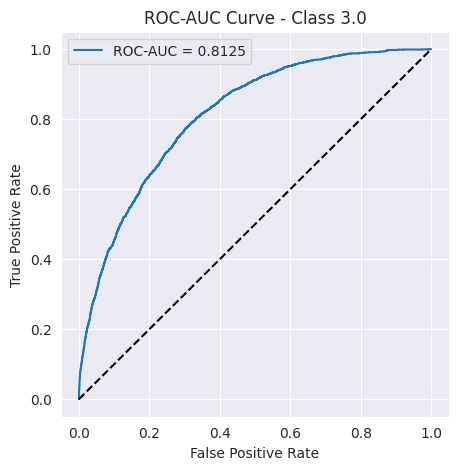

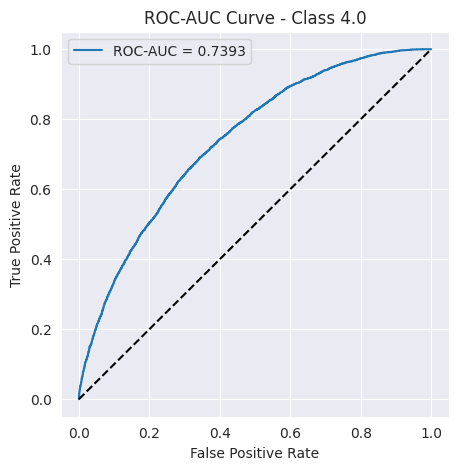

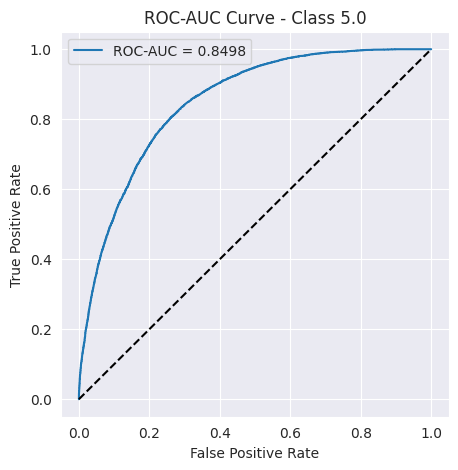

In [ ]:
plot_roc_auc(y_test_bin, y_pred_proba, classes)

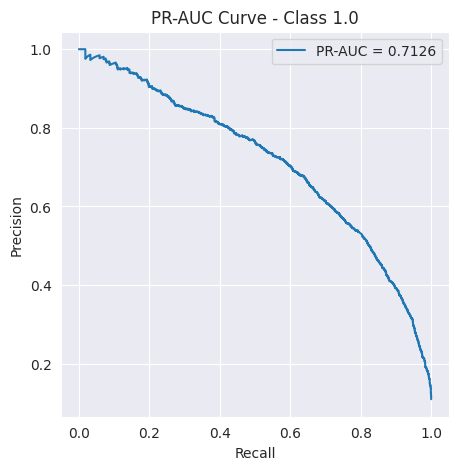

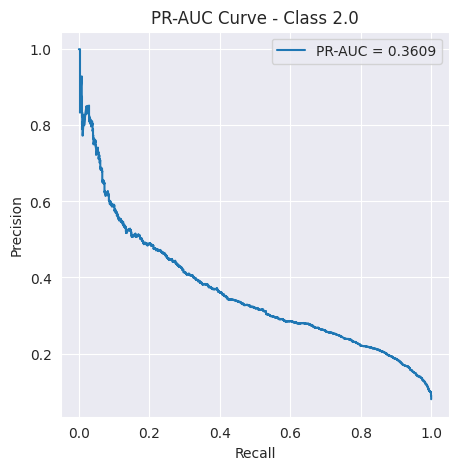

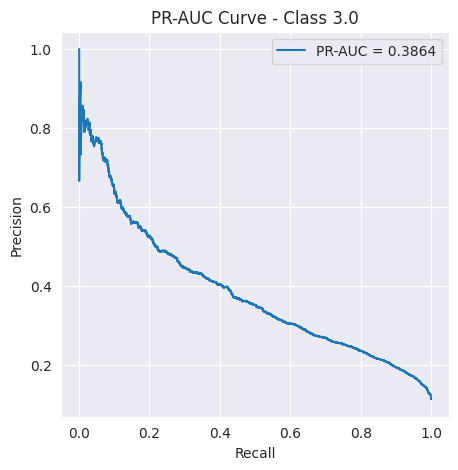

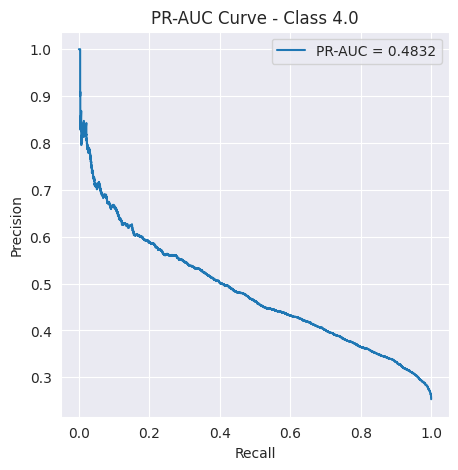

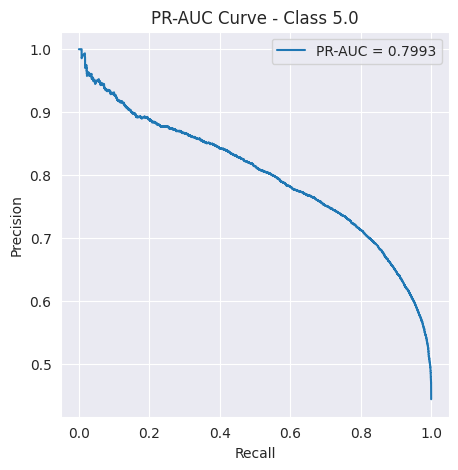

In [ ]:
plot_pr_auc(y_test_bin, y_pred_proba, classes)

In [ ]:
print('PR-AUC Score: ', average_precision_score(y_test_bin,y_pred_proba,average='macro'))

PR-AUC Score:  0.5486507645687073


In [ ]:
best_thresholds = find_best_thresholds(y_test_bin, y_pred_proba, classes)

Class 1.0 | best threshold = 0.2651 | F1=0.6573
Class 2.0 | best threshold = 0.1388 | F1=0.3937
Class 3.0 | best threshold = 0.1706 | F1=0.4144
Class 4.0 | best threshold = 0.2627 | F1=0.5115
Class 5.0 | best threshold = 0.4086 | F1=0.7595


In [ ]:
y_pred_new = predict(y_pred_proba, best_thresholds, classes)

print('Accuracy Score：', accuracy_score(y_test,y_pred_new))
print('\n',classification_report(y_test,y_pred_new))

Accuracy Score： 0.6010715537529417

               precision    recall  f1-score   support

         1.0       0.68      0.63      0.65      2182
         2.0       0.42      0.25      0.31      1597
         3.0       0.47      0.24      0.32      2271
         4.0       0.46      0.41      0.43      5057
         5.0       0.67      0.86      0.75      8864

    accuracy                           0.60     19971
   macro avg       0.54      0.48      0.49     19971
weighted avg       0.58      0.60      0.58     19971



# Transformer-based models

In [ ]:
df.head()

stars                                               text  length  \
0    3.0  If you decide to eat here, just be aware it is...     513   
1    5.0  I've taken a lot of spin classes over the year...     829   
2    3.0  Family diner. Had the buffet. Eclectic assortm...     339   
3    5.0  Wow! Yummy, different, delicious. Our favorite...     243   
4    4.0  Cute interior and owner (?) gave us tour of up...     534   

                                              tokens  num_of_tokens  
0  [decide, eat, aware, going, take, 2, hours, be...             44  
1  [taken, lot, spin, classes, years, nothing, co...             80  
2  [family, diner, buffet, eclectic, assortment, ...             39  
3  [wow, yummy, different, delicious, favorite, l...             23  
4  [cute, interior, owner, gave, us, tour, upcomi...             64

## Load pretrained models

In [ ]:
pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load tokenizer and model from transformers

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model= AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train-Val-Test Split

In [ ]:
df.describe()

stars        length  num_of_tokens
count  99851.000000  99851.000000   99851.000000
mean       3.842495    548.736247      51.424653
std        1.354914    501.769251      45.991793
min        1.000000      3.000000       1.000000
25%        3.000000    226.000000      22.000000
50%        4.000000    395.000000      37.000000
75%        5.000000    693.000000      65.000000
max        5.000000   5000.000000     617.000000

In [ ]:
# prepare test dataset, which accounts for 10%

X_train_original, X_test, y_train_original, y_test = train_test_split(
              df['text'].astype(str),
              df['stars'],
              test_size=0.2,
              random_state=42,
              stratify=df['stars'])

In [ ]:
# get training and validation datasets

X_train, X_val, y_train, y_val = train_test_split(
    X_train_original,
    y_train_original,
    test_size=0.1,
    random_state=42,
    stratify=y_train_original)


## Embeddings

In [ ]:
# define a function to get embeddings

def get_tokens(texts, tokenizer, max_len=128):

    return tokenizer(
        texts,
        padding="max_length",       # pad to the max length
        truncation=True,            # truncate extra long text
        max_length=max_len,
        return_tensors="pt"         # return tensors
    )

train_embedding = get_tokens(X_train.astype(str).tolist(), tokenizer, max_len=128)
val_embedding = get_tokens(X_val.astype(str).tolist(), tokenizer, max_len=128)
test_embedding  = get_tokens(X_test.astype(str).tolist(), tokenizer, max_len=128)


## Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# encode labels
encoder = LabelEncoder()
y_train_encode = encoder.fit_transform(y_train)
y_val_encode = encoder.transform(y_val)
y_test_encode = encoder.transform(y_test)

In [ ]:
# build datasets

train_dataset = TensorDataset(
    train_embedding['input_ids'],
    train_embedding['attention_mask'],
    torch.tensor(y_train_encode)
)

val_dataset = TensorDataset(
    val_embedding['input_ids'],
    val_embedding['attention_mask'],
    torch.tensor(y_val_encode)
)

test_dataset = TensorDataset(
    test_embedding['input_ids'],
    test_embedding['attention_mask'],
    torch.tensor(y_test_encode))

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

## Optimizer & Scheduler

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# hyperparameters
epochs = 3
learning_rate = 2e-6
epsilon = 1e-8
warmup_ratio = 0.1

# steps
t_total = len(train_loader) * epochs
warmup_steps = int(t_total * warmup_ratio)

# optimizer
optimizer = AdamW(bert_model.parameters(),lr=learning_rate,eps=epsilon)

# shceduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total
)

print(f"Total steps: {t_total}, Warmup steps: {warmup_steps}")


Total steps: 13482, Warmup steps: 1348


## Training

In [ ]:
from tqdm.notebook import tqdm
from tqdm import trange
from torch.nn.utils import clip_grad_norm_

# send to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

for epoch in trange(epochs):
    bert_model.train()
    total_loss = 0.0

    # show the progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for step, batch in enumerate(progress_bar):
        optimizer.zero_grad()

        # send to GPU
        batch = tuple(t.to(device) for t in batch)

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        # forward propagation
        outputs = bert_model(**inputs)
        loss = outputs.loss

        # back propagation
        loss.backward()

        # clip gradients
        clip_grad_norm_(bert_model.parameters(), max_norm=1.0)

        # update parameters
        optimizer.step()

        # update scheduler
        scheduler.step()

        # calculate total loss
        total_loss += loss.item()

        # update progress bar
        progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    # calculate average loss and show
    avg_epoch_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Average Training Loss: {avg_epoch_loss:.4f}")

# save the model
output_dir = "outputs/bert_ce"
tokenizer.save_pretrained(output_dir)
bert_model.save_pretrained(output_dir)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3:   0%|          | 0/4494 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [06:14<12:28, 374.26s/it]


Epoch 1 | Average Training Loss: 0.9961


Epoch 2/3:   0%|          | 0/4494 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [12:25<06:12, 372.58s/it]


Epoch 2 | Average Training Loss: 0.7717


Epoch 3/3:   0%|          | 0/4494 [00:00<?, ?it/s]

100%|██████████| 3/3 [18:37<00:00, 372.60s/it]


Epoch 3 | Average Training Loss: 0.7401


## Validation

In [ ]:
# define a validation function

def validation(model, dataloader, device):
    model.eval()

    preds = []
    probs = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = [t.to(device) for t in batch]
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1]
            }
            outputs = model(**inputs)

            logits = outputs.logits
            prob = torch.softmax(logits, dim=1)

            probs.append(prob.cpu().numpy())
            preds.append(torch.argmax(prob, dim=1).cpu().numpy())
            labels.append(batch[2].cpu().numpy())

    return (
        np.concatenate(labels),
        np.concatenate(preds),
        np.concatenate(probs),
    )


In [ ]:
# load the model

from transformers import BertTokenizer, BertForSequenceClassification

model_path = "outputs/bert_ce"
bert_model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
y_true, y_pred, y_pred_proba = validation(bert_model, val_loader, device)

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.6795192789183776
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       873
           1       0.48      0.41      0.44       639
           2       0.51      0.43      0.47       908
           3       0.57      0.51      0.54      2023
           4       0.77      0.86      0.82      3545

    accuracy                           0.68      7988
   macro avg       0.62      0.60      0.61      7988
weighted avg       0.67      0.68      0.67      7988



In [ ]:
classes = sorted(np.unique(y_true))
y_val_bin = label_binarize(y_true, classes=classes)

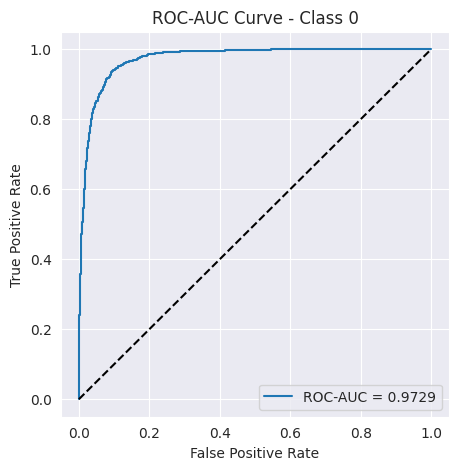

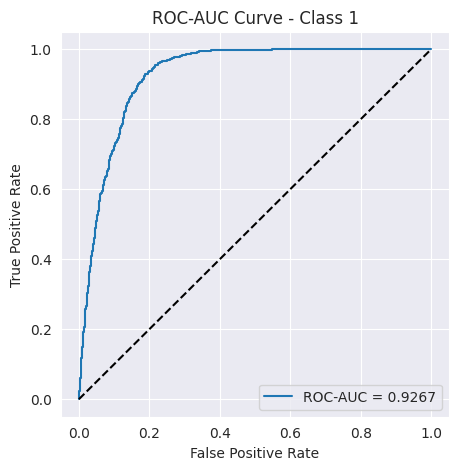

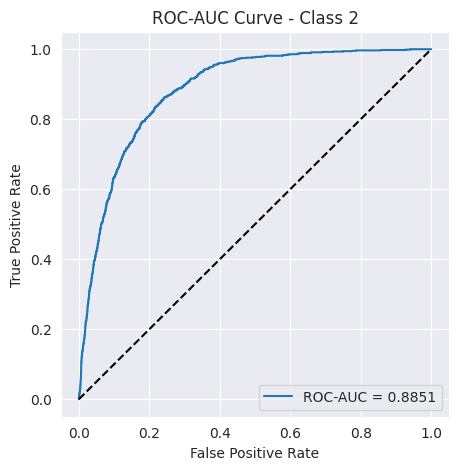

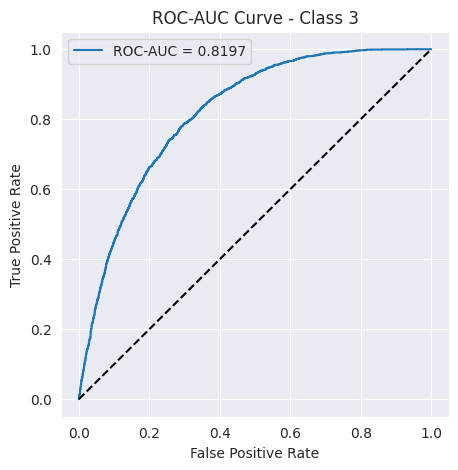

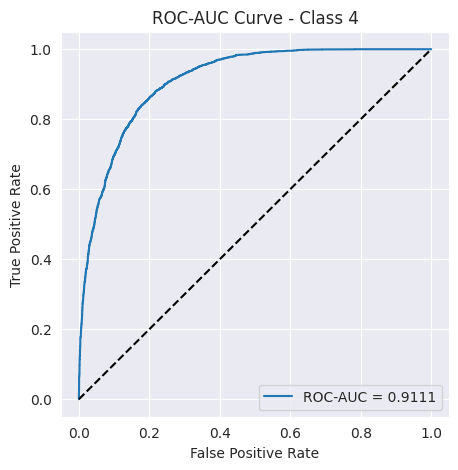

In [ ]:
plot_roc_auc(y_val_bin, y_pred_proba, classes)

Macro average ROC-AUC score : 0.90

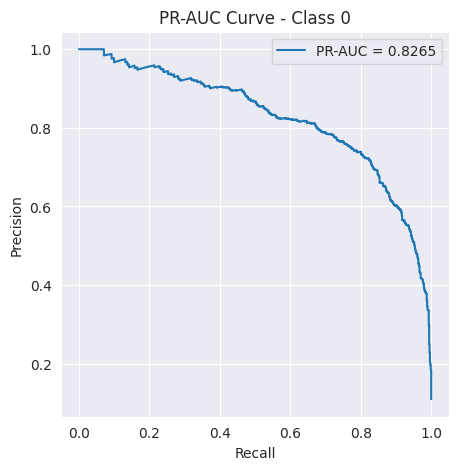

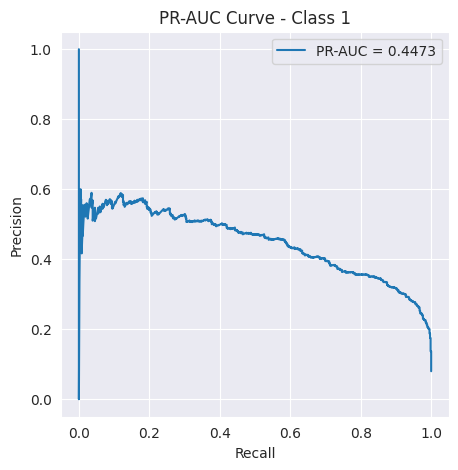

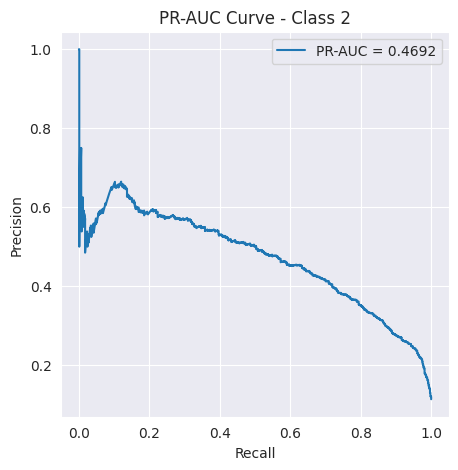

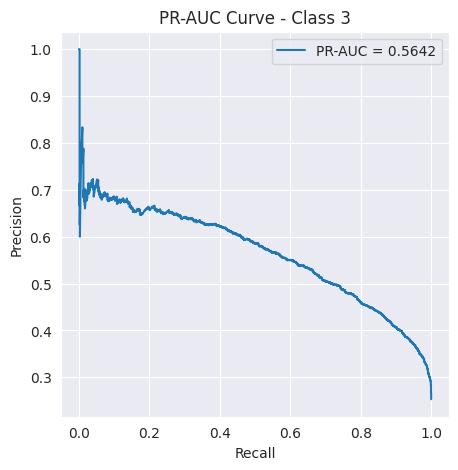

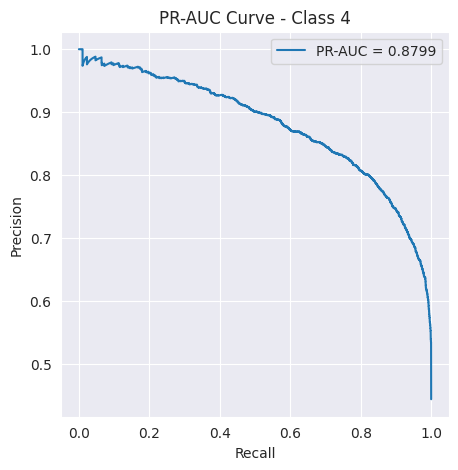

In [ ]:
plot_pr_auc(y_val_bin, y_pred_proba, classes)

Macro average PR-AUC score : 0.64

In [ ]:
best_thresholds = find_best_thresholds(y_val_bin, y_pred_proba, classes)

Class 0 | best threshold = 0.3618 | F1=0.7694
Class 1 | best threshold = 0.3266 | F1=0.5117
Class 2 | best threshold = 0.2488 | F1=0.5273
Class 3 | best threshold = 0.2538 | F1=0.5932
Class 4 | best threshold = 0.4209 | F1=0.8173


In [ ]:
y_pred_new = predict(y_pred_proba, best_thresholds, classes)

print("New Accuracy:", accuracy_score(y_true, y_pred_new))
print(classification_report(y_true, y_pred_new))

New Accuracy: 0.6795192789183776
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       873
           1       0.48      0.41      0.44       639
           2       0.51      0.44      0.47       908
           3       0.57      0.51      0.54      2023
           4       0.78      0.86      0.82      3545

    accuracy                           0.68      7988
   macro avg       0.62      0.60      0.61      7988
weighted avg       0.67      0.68      0.67      7988



## Embedding Visualization

In [ ]:
# define a function to extract embeddings for visualization

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = [t.to(device) for t in batch]
            input_ids, attention_mask, label = batch

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )

            # choose the CLS of the final layer
            last_hidden = outputs.hidden_states[-1]
            cls_emb = last_hidden[:, 0, :].cpu().numpy()

            embeddings.append(cls_emb)
            labels.append(label.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    return embeddings, labels

In [ ]:
embeddings, labels = extract_embeddings(bert_model, val_loader, device)

In [ ]:
print('Embeddings: ',embeddings.shape)
print('Labels: ',labels.shape)

Embeddings:  (7988, 768)
Labels:  (7988,)


In [ ]:
# use PCA to reduce dimension firstly, because current dimension is 768, very high

from sklearn.decomposition import PCA

pca_ce = PCA(n_components=50).fit_transform(embeddings)

In [ ]:
# use UMAP to reduce to 2 dimensions

import umap.umap_ as umap

umap_ce = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(pca_ce)

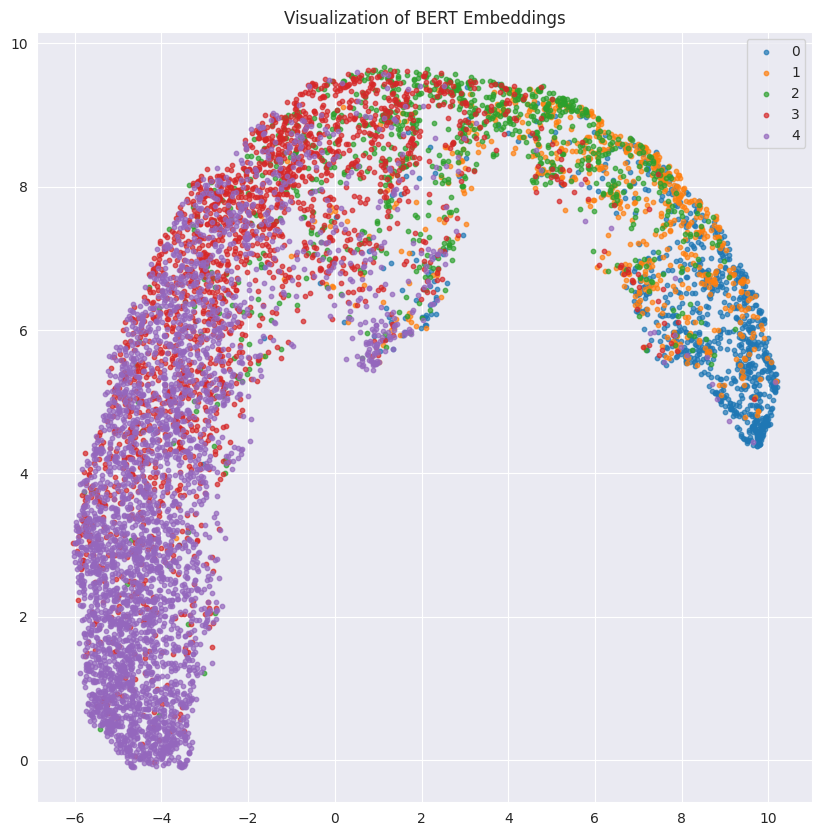

In [ ]:
plt.figure(figsize=(10,10))

for cls in np.unique(labels):
    idx = labels == cls
    plt.scatter(umap_ce[idx,0], umap_ce[idx,1], s=10, alpha=0.7, label=str(cls))

plt.legend()
plt.title("Visualization of BERT Embeddings")
plt.show()


# Weighted CE

In [ ]:
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# hyperparameters
epochs = 3
learning_rate = 2e-6
epsilon = 1e-8
warmup_ratio = 0.1

# steps
t_total = len(train_loader) * epochs
warmup_steps = int(t_total * warmup_ratio)

# optimizer
optimizer = AdamW(bert_model.parameters(),lr=learning_rate,eps=epsilon)

# shceduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total
)

print(f"Total steps: {t_total}, Warmup steps: {warmup_steps}")

Total steps: 13482, Warmup steps: 1348


In [ ]:
from collections import Counter

# calculate sample numbers of each class
label_counts = Counter(train_dataset.tensors[2].cpu().numpy())
samples_per_class = [label_counts[i] for i in range(len(label_counts))]

print("Samples per class:", samples_per_class)


Samples per class: [7853, 5748, 8175, 18206, 31910]


In [ ]:
samples_per_class = torch.tensor([7853, 5748, 8175, 18206, 31910], dtype=torch.float)

# compute weights and normalization
class_weights = 1.0 / samples_per_class
class_weights = class_weights / class_weights.sum() * len(samples_per_class)

class_weights = class_weights.to(device)

print("Class weights:", class_weights)


Class weights: tensor([1.2487, 1.7059, 1.1995, 0.5386, 0.3073], device='cuda:0')


In [ ]:
# loss function
import torch.nn as nn

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
for epoch in range(epochs):
    bert_model.train()
    total_loss = 0.0

    # show progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for step, batch in enumerate(progress_bar):
        optimizer.zero_grad()

        # send to GPU
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        # forward propagation
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs[1]

        # compute loss with weighted CE
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # backward propagation
        loss.backward()

        # clip gradients
        clip_grad_norm_(bert_model.parameters(), max_norm=1.0)

        # update parameters and scheduler
        optimizer.step()
        scheduler.step()

        # update progress bar
        if step % 50 == 0:
            progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    # calculate average loss
    avg_epoch_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{epochs} | Average Training Loss: {avg_epoch_loss:.4f}\n")

# save the model
output_dir = "outputs/bert_weighted_ce"
bert_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Epoch 1/3:   0%|          | 0/4494 [00:00<?, ?it/s]


Epoch 1/3 | Average Training Loss: 1.1401



Epoch 2/3:   0%|          | 0/4494 [00:00<?, ?it/s]


Epoch 2/3 | Average Training Loss: 0.9009



Epoch 3/3:   0%|          | 0/4494 [00:00<?, ?it/s]


Epoch 3/3 | Average Training Loss: 0.8617



('outputs/bert_weighted_ce/tokenizer_config.json',
 'outputs/bert_weighted_ce/special_tokens_map.json',
 'outputs/bert_weighted_ce/vocab.txt',
 'outputs/bert_weighted_ce/added_tokens.json')

In [ ]:
model_path = "outputs/bert_weighted_ce"

bert_model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
y_true, y_pred, y_pred_proba = validation(bert_model, val_loader, device)

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.6596144216324487
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       873
           1       0.44      0.53      0.48       639
           2       0.47      0.52      0.49       908
           3       0.53      0.55      0.54      2023
           4       0.82      0.76      0.79      3545

    accuracy                           0.66      7988
   macro avg       0.61      0.62      0.61      7988
weighted avg       0.67      0.66      0.66      7988



In [ ]:
embeddings, labels = extract_embeddings(bert_model, val_loader, device)

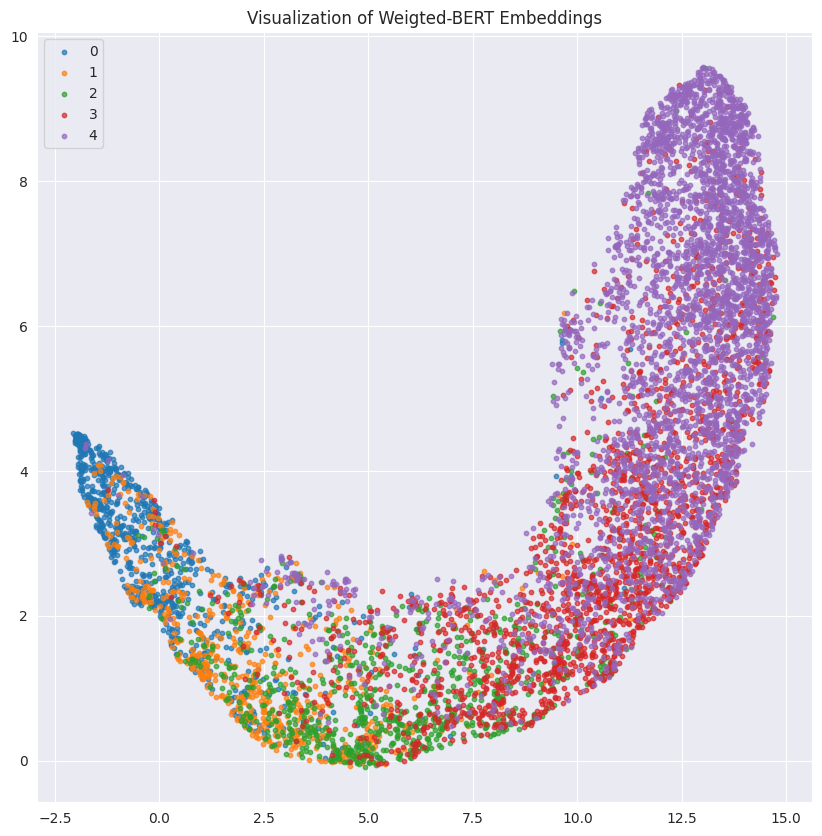

In [ ]:
pca = PCA(n_components=50).fit_transform(embeddings)

umap_weightedCE = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(pca)

plt.figure(figsize=(10,10))

for cls in np.unique(labels):
    idx = labels == cls
    plt.scatter(umap_weightedCE[idx,0], umap_weightedCE[idx,1], s=10, alpha=0.7, label=str(cls))

plt.legend()
plt.title("Visualization of Weigted-BERT Embeddings")
plt.show()

---

# Weighted Focal Loss

In [ ]:
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# hyperparameters
epochs = 3
learning_rate = 2e-6
epsilon = 1e-8
warmup_ratio = 0.1

# steps
t_total = len(train_loader) * epochs
warmup_steps = int(t_total * warmup_ratio)

# optimizer
optimizer = AdamW(bert_model.parameters(),lr=learning_rate,eps=epsilon)

# shceduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total
)

print(f"Total steps: {t_total}, Warmup steps: {warmup_steps}")

Total steps: 13482, Warmup steps: 1348


In [ ]:
import torch.nn.functional as F

class WeightedFocalLoss(nn.Module):
    def __init__(self, class_weights=None, gamma=1):
        super().__init__()
        self.class_weights = class_weights
        self.gamma = gamma

    def forward(self, logits, labels):
        ce_loss = F.cross_entropy(logits, labels, weight=self.class_weights, reduction='none')
        probs = F.softmax(logits, dim=1)
        pt = probs.gather(1, labels.unsqueeze(1)).squeeze()  # get probability of true label

        # compute focal factor
        focal_factor = (1 - pt) ** self.gamma

        # compute focal loss
        loss = focal_factor * ce_loss
        return loss.mean()

In [ ]:
# define weighted focal loss function
criterion = WeightedFocalLoss(class_weights=class_weights, gamma=1)

In [ ]:
# send model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

for epoch in range(epochs):
    bert_model.train()
    total_loss = 0.0

    # show progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for step, batch in enumerate(progress_bar):
        optimizer.zero_grad()

        # send to GPU
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        # forward propagation
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs[1]

        # compute loss with class-balanced CE
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # backward propagation
        loss.backward()

        # clip gradients
        clip_grad_norm_(bert_model.parameters(), max_norm=1.0)

        # update parameters and scheduler
        optimizer.step()
        scheduler.step()

        # update progress bar
        if step % 50 == 0:
            progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    # calculate average loss
    avg_epoch_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{epochs} | Average Training Loss: {avg_epoch_loss:.4f}\n")

# save the model
output_dir = "outputs/bert_weighted_focal_loss"
bert_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Epoch 1/3:   0%|          | 0/4494 [00:00<?, ?it/s]


Epoch 1/3 | Average Training Loss: 0.5641



Epoch 2/3:   0%|          | 0/4494 [00:00<?, ?it/s]


Epoch 2/3 | Average Training Loss: 0.4119



Epoch 3/3:   0%|          | 0/4494 [00:00<?, ?it/s]


Epoch 3/3 | Average Training Loss: 0.3889



('outputs/bert_weighted_focal_loss/tokenizer_config.json',
 'outputs/bert_weighted_focal_loss/special_tokens_map.json',
 'outputs/bert_weighted_focal_loss/vocab.txt',
 'outputs/bert_weighted_focal_loss/added_tokens.json')

In [ ]:
model_path = "outputs/bert_weighted_focal_loss"

bert_model = BertForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
y_true, y_pred, y_pred_proba = validation(bert_model, val_loader, device)

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.6533550325488232
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       873
           1       0.44      0.53      0.48       639
           2       0.45      0.52      0.48       908
           3       0.53      0.56      0.54      2023
           4       0.82      0.75      0.78      3545

    accuracy                           0.65      7988
   macro avg       0.60      0.62      0.61      7988
weighted avg       0.67      0.65      0.66      7988



In [ ]:
embeddings, labels = extract_embeddings(bert_model, val_loader, device)

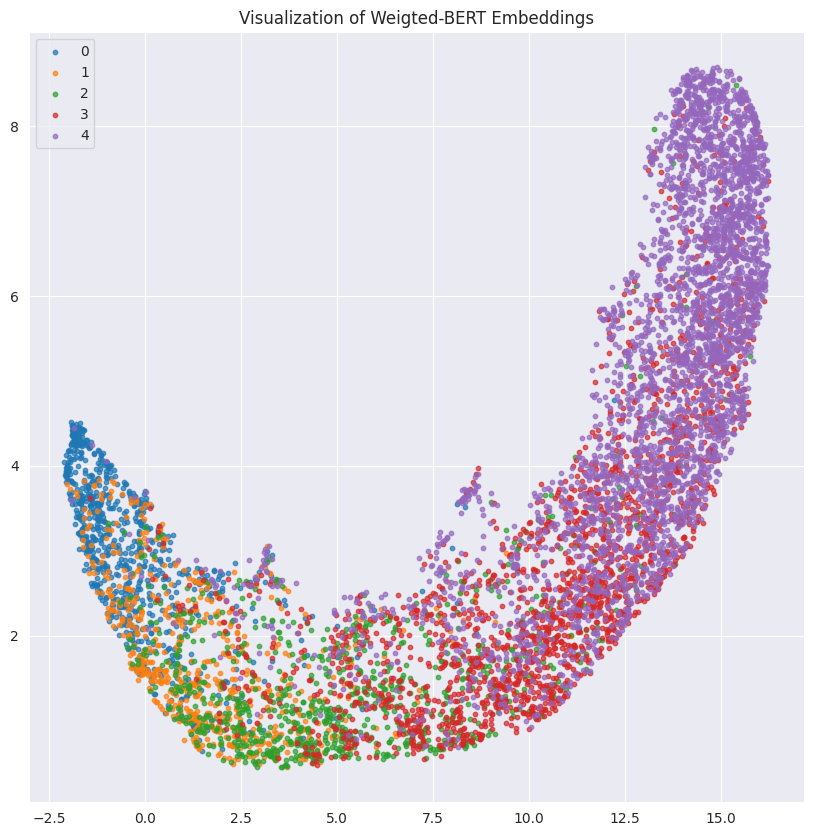

In [ ]:
pca = PCA(n_components=50).fit_transform(embeddings)

umap_weightedCE = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(pca)

plt.figure(figsize=(10,10))

for cls in np.unique(labels):
    idx = labels == cls
    plt.scatter(umap_weightedCE[idx,0], umap_weightedCE[idx,1], s=10, alpha=0.7, label=str(cls))

plt.legend()
plt.title("Visualization of Weigted-BERT Embeddings")
plt.show()